In [1]:
import os
os.chdir('/Users/jjaniak/Documents/studia/projekt/gradient')

import geopandas as gpd
import pandas as pd
import json

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import shap
import numpy as np

from shapely.wkt import loads

from esda.moran import Moran_Local
import libpysal

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from src.embedders.osm_data_embedder import OSMDataEmbedder
from srai.regionalizers import geocode_to_region_gdf
from srai.embedders import CountEmbedder
from srai.regionalizers import H3Regionalizer
from srai.loaders.osm_loaders.filters import OsmTagsFilter

from IPython.display import display

pd.set_option("display.max_columns", None)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

json_folder_path = "notebooks/accident_analysis/out/data_analysis_results/"

/Users/jjaniak/Documents/studia/projekt/gradient/.conda/lib/python3.8/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.2-CAPI-1.17.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/var/folders/4k/8js3jm9n457cm4_v631zyrkw0000gn/T/ipykernel_70620/3523676952.py:4: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get sp

In [2]:
city_name = "Pozna\u0144"
nominatim_city_name = "Pozna\u0144, Poland"
year = 2022

In [3]:
# Parameters
city_name = "Warszawa"
nominatim_city_name = "Warszawa, Poland"
year = 2022


## Functions

In [4]:
query: OsmTagsFilter = {"highway": True, "railway": True, "route": True, "amenity": True}

def rename_columns_for_saving(hex_and_features_gdf):
    # Define a mapping for renaming columns
    column_mapping = {
        "highway": "H_",
        "railway": "R_",
        "amenity": "A_",
        "route": "RO_",
    }

    # Rename columns based on the defined mapping
    for prefix, replacement in column_mapping.items():
        columns_to_rename = [col for col in hex_and_features_gdf.columns if col.startswith(prefix + "_")]
        new_column_names = [replacement + col[len(prefix) + 1:] for col in columns_to_rename]
        hex_and_features_gdf.rename(columns=dict(zip(columns_to_rename, new_column_names)), inplace=True)

    return hex_and_features_gdf

def create_hex_gds(h3_resolution, city_name=city_name):
    data_embedder = OSMDataEmbedder(
        area=geocode_to_region_gdf(nominatim_city_name),
        embedder=CountEmbedder(),
        regionalizer=H3Regionalizer(resolution=h3_resolution),
        query=query,
    )
    filename = f"data/baseline-datasets/in/{city_name}-hex-res-{h3_resolution}-and-features_with_amenity-gdf_fixed_names.shp"
    if not os.path.exists(filename):
        hex_and_features_gdf = data_embedder.make_embeddings()  # type: ignore
        hex_and_features_gdf_fixed_names = rename_columns_for_saving(hex_and_features_gdf)
        hex_and_features_gdf_fixed_names.to_file(
            filename,
            index=True,
        )
    else:
        hex_and_features_gdf = gpd.read_file(filename)
        hex_and_features_gdf.set_index("region_id", inplace=True)

    return hex_and_features_gdf


def get_accidents_gdf(h3_resolution, city_name=city_name, year=year):
    filename = f"data/accidents_in_hex/{city_name}_accidents_{year}_res{h3_resolution}.csv"
    if not os.path.exists(filename):
        raise FileNotFoundError(f"The file {filename} does not exist.")
    else:
        accidents_df = pd.read_csv(filename)
        accidents_df['geometry'] = accidents_df['geometry'].apply(loads)
        accidents_gdf = gpd.GeoDataFrame(accidents_df, geometry='geometry', crs="EPSG:4326")
        return accidents_gdf
    
def merge_gdf(resolution):
    filename = f"data/accidents_in_hex/{city_name}_accidents_and_features_{year}_res{resolution}.shp"
    if not os.path.exists(filename):
        hex_and_features_gdf = create_hex_gds(h3_resolution=resolution, city_name=city_name)
        accidents_gdf = get_accidents_gdf(h3_resolution=resolution, city_name=city_name, year=year)
        merged_gdf = gpd.sjoin(left_df=accidents_gdf, right_df=hex_and_features_gdf, how='inner', op='intersects')
        merged_gdf = merged_gdf.drop(columns='index_right')
        merged_gdf['num_accidents'] = merged_gdf['count'].astype(int)
        merged_gdf.drop(columns=['count'], inplace=True)
        merged_gdf['binary_accidents'] = 0  # Initialize with 0
        merged_gdf.loc[merged_gdf["num_accidents"] > 0, "binary_accidents"] = 1.0
        merged_gdf.to_file(
            filename,
            index=True,
        )
    else:
        merged_gdf = gpd.read_file(filename)
        merged_gdf.set_index("region_id", inplace=True)
    
    merged_gdf.rename(columns={'num_accide': 'num_accidents', 'binary_acc': 'binary_accidents'}, inplace=True)
    return merged_gdf

In [5]:
def local_moran(df, column):
    w = libpysal.weights.Queen.from_dataframe(df)
    y = df[column].values
    moran_loc = Moran_Local(y, w)
    return moran_loc.Is, moran_loc.p_sim, moran_loc.q

In [6]:
from enum import Enum

class FeatureGoups(Enum):
    HIGHWAY = "H"
    RAILWAY = "R"
    AMENITY = "A"
    ROUTE  = "RO"
    

def analyze_features(merged_gdf:pd.DataFrame, feature_group: FeatureGoups):
    
    # Filter columns starting with feature group name
    feature_group_columns = merged_gdf.columns[merged_gdf.columns.str.startswith(feature_group.value)]

    # Sum values
    sum_feature_values = merged_gdf[feature_group_columns].sum()
    
    if sum_feature_values.size == 1:
        print(f"Found only one feature for feature group {feature_group.name}")
        display(sum_feature_values)
        return []
        
    else:
        plt.figure(figsize=(10, 6))
        sns.histplot(sum_feature_values, bins=50, kde=True, color='skyblue', edgecolor='black')
        plt.title(f'Histogram of {feature_group.name} Features')
        plt.xlabel('Sum')
        plt.ylabel('Frequency')
        plt.show()

        quartiles = sum_feature_values.quantile([0.25, 0.5, 0.75])

        iqr = quartiles[0.75] - quartiles[0.25]
        lower_bound = quartiles[0.25] - 1.5 * iqr
        upper_bound = quartiles[0.75] + 1.5 * iqr

        most_common_features = list(sum_feature_values[(sum_feature_values > upper_bound)].index)
        least_common_features = list(sum_feature_values[(sum_feature_values < lower_bound)].index)
        display(sum_feature_values.describe())
        print(f"\nMost common features for {feature_group.name}: \n {most_common_features}")
        if least_common_features:
            print(f"\nLeast common features for {feature_group.name}: \n {least_common_features}")
        
        return most_common_features
    
    
def analyze_imbalance(merged_gdf, feature_group):
    feature_group_columns = list(merged_gdf.columns[merged_gdf.columns.str.startswith(feature_group.value)]) + ['binary_accidents']
    grouped_data = merged_gdf[feature_group_columns].groupby('binary_accidents').sum()
    percentage_data = grouped_data.div(grouped_data.sum(axis=0))
        
    imbalance_ratio = abs(grouped_data.diff(axis=0) / grouped_data.sum(axis=0)).round(2)
    imbalance_ratio = imbalance_ratio.loc[1]
    
    print(f"\nMetrics of Imbalance in {feature_group.name}")
    if imbalance_ratio.size > 1:
        display(imbalance_ratio.T.describe())
    else:
        display(imbalance_ratio)
    
    high_imbalance_features = imbalance_ratio[imbalance_ratio >= 0.5]
    if high_imbalance_features.size > 0:
        print(f"\nThere are {len(high_imbalance_features)} high imbalance features in {feature_group.name}")
        for feature in high_imbalance_features.index:
            print(feature)
        display(percentage_data[high_imbalance_features.index])

        return high_imbalance_features.index
    else:
        return []
    RAILWAY = "railway"
    AMENITY = "amenity"
    ROUTE  = "route"
    

def analyze_features(merged_gdf:pd.DataFrame, feature_group: FeatureGoups):
    
    # Filter columns starting with feature group name
    feature_group_columns = merged_gdf.columns[merged_gdf.columns.str.startswith(feature_group.value)]

    # Sum values
    sum_feature_values = merged_gdf[feature_group_columns].sum()
    
    if sum_feature_values.size == 1:
        print(f"Found only one feature for feature group {feature_group.name}")
        display(sum_feature_values)
        return []
        
    else:
        plt.figure(figsize=(10, 6))
        sns.histplot(sum_feature_values, bins=50, kde=True, color='skyblue', edgecolor='black')
        plt.title(f'Histogram of {feature_group.name} Features')
        plt.xlabel('Sum')
        plt.ylabel('Frequency')
        plt.show()

        quartiles = sum_feature_values.quantile([0.25, 0.5, 0.75])

        iqr = quartiles[0.75] - quartiles[0.25]
        lower_bound = quartiles[0.25] - 1.5 * iqr
        upper_bound = quartiles[0.75] + 1.5 * iqr

        most_common_features = list(sum_feature_values[(sum_feature_values > upper_bound)].index)
        least_common_features = list(sum_feature_values[(sum_feature_values < lower_bound)].index)
        display(sum_feature_values.describe())
        print(f"\nMost common features for {feature_group.name}: \n {most_common_features}")
        if least_common_features:
            print(f"\nLeast common features for {feature_group.name}: \n {least_common_features}")
        
        return most_common_features
    
    
def analyze_imbalance(merged_gdf, feature_group):
    feature_group_columns = list(merged_gdf.columns[merged_gdf.columns.str.startswith(feature_group.value)]) + ['binary_accidents']
    grouped_data = merged_gdf[feature_group_columns].groupby('binary_accidents').sum()
    percentage_data = grouped_data.div(grouped_data.sum(axis=0))
        
    imbalance_ratio = abs(grouped_data.diff(axis=0) / grouped_data.sum(axis=0)).round(2)
    imbalance_ratio = imbalance_ratio.loc[1]
    
    print(f"\nMetrics of Imbalance in {feature_group.name}")
    if imbalance_ratio.size > 1:
        display(imbalance_ratio.T.describe())
    else:
        display(imbalance_ratio)
    
    high_imbalance_features = imbalance_ratio[imbalance_ratio >= 0.5]
    if high_imbalance_features.size > 0:
        print(f"\nThere are {len(high_imbalance_features)} high imbalance features in {feature_group.name}:")
        for feature in high_imbalance_features.index:
            print(feature)
        display(percentage_data[high_imbalance_features.index])

        return high_imbalance_features.index
    else:
        return []

In [7]:
def correlation_analysis(merged_gdf, resolution):
    
    all_features = merged_gdf.drop(columns=['geometry', 'region_id', 'num_accidents', 'binary_accidents']).columns.to_list()
    
    correlation_matrix = merged_gdf[all_features + ['binary_accidents']].corr()
    correlation_values = correlation_matrix['binary_accidents']

    correlation_metrics = correlation_values.drop('binary_accidents').describe()

    # Filter features based on IQR 
    high_corr_features = correlation_values[(correlation_values >= 0.2) | (correlation_values <= -0.2)].index.to_list()
    low_corr_features = correlation_values[(correlation_values < 0.2) & (correlation_values > -0.2)].index.to_list()

    high_corr_features.remove('binary_accidents')
    correlation_matrix_best_features = merged_gdf[high_corr_features + ['binary_accidents']].corr()

    if high_corr_features != []:
        plt.figure(figsize=(14, 12))
        sns.heatmap(correlation_matrix_best_features, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={'size': 6})
        plt.title(f'Correlation Heatmap (best features) for resolution = {resolution}')
        plt.show()

    return high_corr_features, low_corr_features, correlation_metrics

In [8]:
def shap_analysis(h3_resolution, merged_gdf, selected_features, city_name=city_name, save_force_plot=False):
    print(f"Analysis for Resolution = {h3_resolution}")
    
    y = merged_gdf['binary_accidents']
    X = merged_gdf[selected_features]

    feature_names = X.columns.tolist()
    
    X_train, X_test, y_train, _ = train_test_split(X, y, test_size=0.3, random_state=42)
    
    scaler = preprocessing.StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=feature_names)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=feature_names)
    
    linear_lr = LogisticRegression(max_iter=1000)
    linear_lr.fit(X_train_scaled, y_train)

    #Przygotowanie przybliżonej próbki tła za pomocą metody k-means.
    background_summary = shap.kmeans(X_train, 10)

    explainer = shap.KernelExplainer(linear_lr.predict_proba, background_summary)

    #Obliczenie SHAP wartości dla danych testowych (X_test), co pozwala na zrozumienie, jak każda zmienna przyczynia się do przewidywanej wartości.
    shap_values = explainer.shap_values(X_test_scaled)

    shap.summary_plot(shap_values, X_test_scaled)

    if save_force_plot:
        shap.initjs()
        p = shap.force_plot(explainer.expected_value[0], shap_values[0], X_test_scaled)
        shap.save_html(json_folder_path + f'{city_name}_res_{h3_resolution}_force_plot_best_features.html', p)

## Analysis

In [9]:
# Set resolutions
resolutions = [8, 9, 10]

# Initialize dataframe and dictionaries to store results
distribution_results = pd.DataFrame(columns=['Resolution', 'Num_Hexes', 'Accidents_Mean', 'Accidents_Std','Binary_Accidents_Mean', 'Binary_Accidents_Std'])

local_moran_results = {} 
highest_imbalance_features_dict = {}


# Loop through resolutions
for resolution in resolutions:
    
    print(f"Analysis for Resolution = {resolution}")
    
    # Create hex dataframes
    merged_gdf = merge_gdf(resolution)
    
    # Accidents Distribution
    new_row = {
        'Resolution': resolution,
        'Num_Hexes': len(merged_gdf),
        'Accidents_Mean': merged_gdf['num_accidents'].mean(),
        'Accidents_Std': merged_gdf['num_accidents'].std(),
        'Binary_Accidents_Mean': merged_gdf['binary_accidents'].mean(),
        'Binary_Accidents_Std': merged_gdf['binary_accidents'].std()
    }
    result_df = pd.DataFrame([new_row], columns=distribution_results.columns)
    distribution_results = pd.concat([distribution_results, result_df], ignore_index=True)

    # Calculate Local Moran's I
    moran_i, p_sim, q = local_moran(merged_gdf, column='num_accidents')
    local_moran_results[resolution] = {'moran_i': moran_i, 'p_sim': p_sim, 'q': q}

Analysis for Resolution = 8


Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
`use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning


Analysis for Resolution = 9


Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
`use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning


Analysis for Resolution = 10


Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
`use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning


### Rozkład wypadków

In [10]:
print("Distribution of Accidents in Hexes:")
display(distribution_results) 

Distribution of Accidents in Hexes:


,Resolution,Num_Hexes,Accidents_Mean,Accidents_Std,Binary_Accidents_Mean,Binary_Accidents_Std
0,8,5670,0.919753,1.693715,0.383069,0.486178
1,9,38209,0.136460,0.471067,0.101102,0.301467
2,10,263515,0.019821,0.154737,0.017908,0.132617


#### Wnioski
- Na niższych rozdzielczościach heksagony mają tendencję do grupowania większej liczby wypadków.
- Odchylenie standardowe liczby wypadków maleje wraz ze wzrostem rozdzielczości. 
- Odchylenie standardowe na skali binarnej jest największe dla rozdzielczości 8 (0.49), co sugeruje większe zróżnicowanie między heksagonami pod względem obecności lub braku wypadków.


### Correlation

Analysis for Resolution = 8


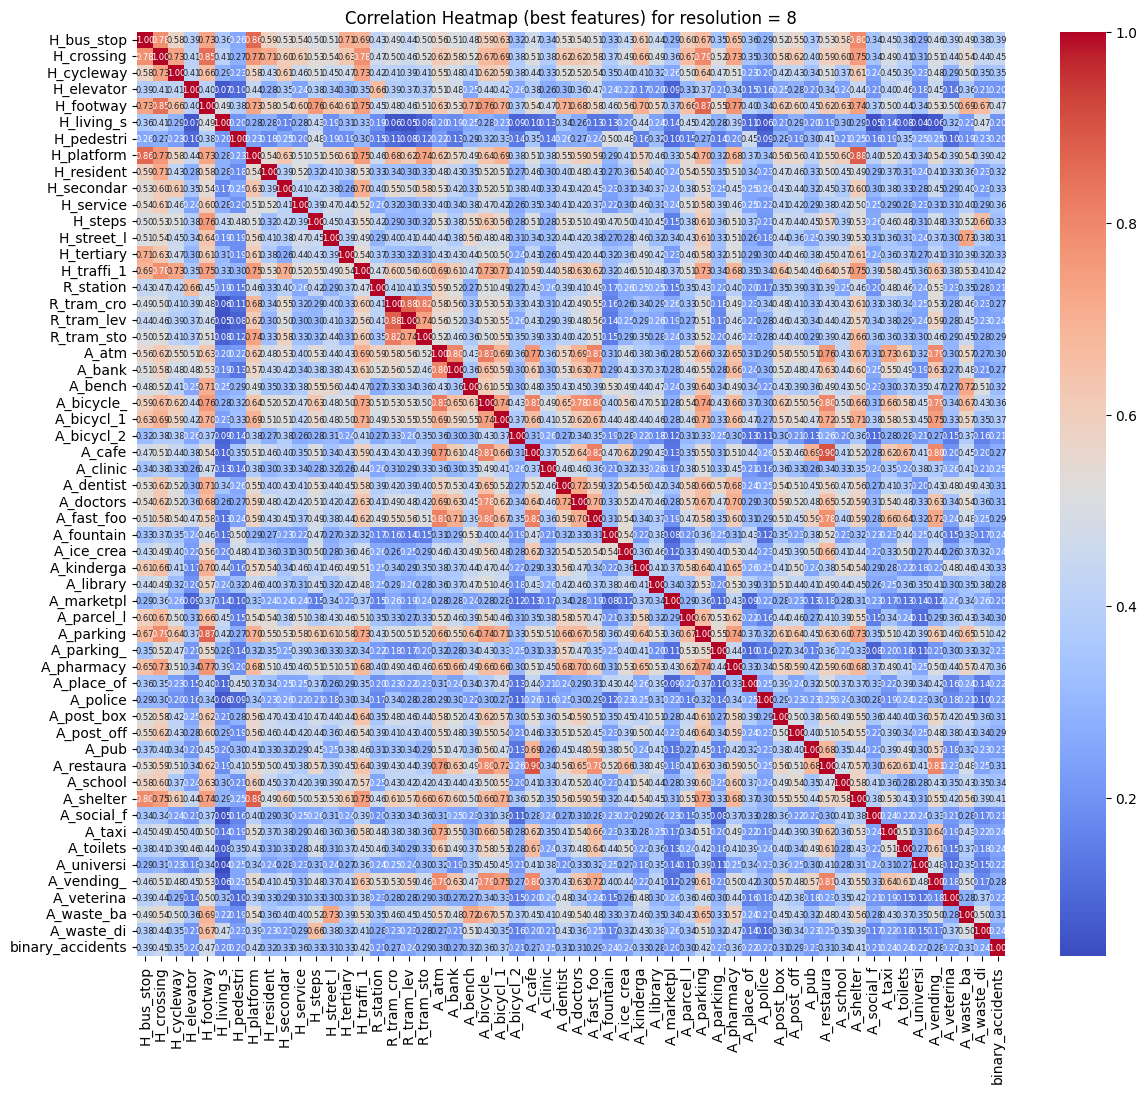

Analysis for Resolution = 9


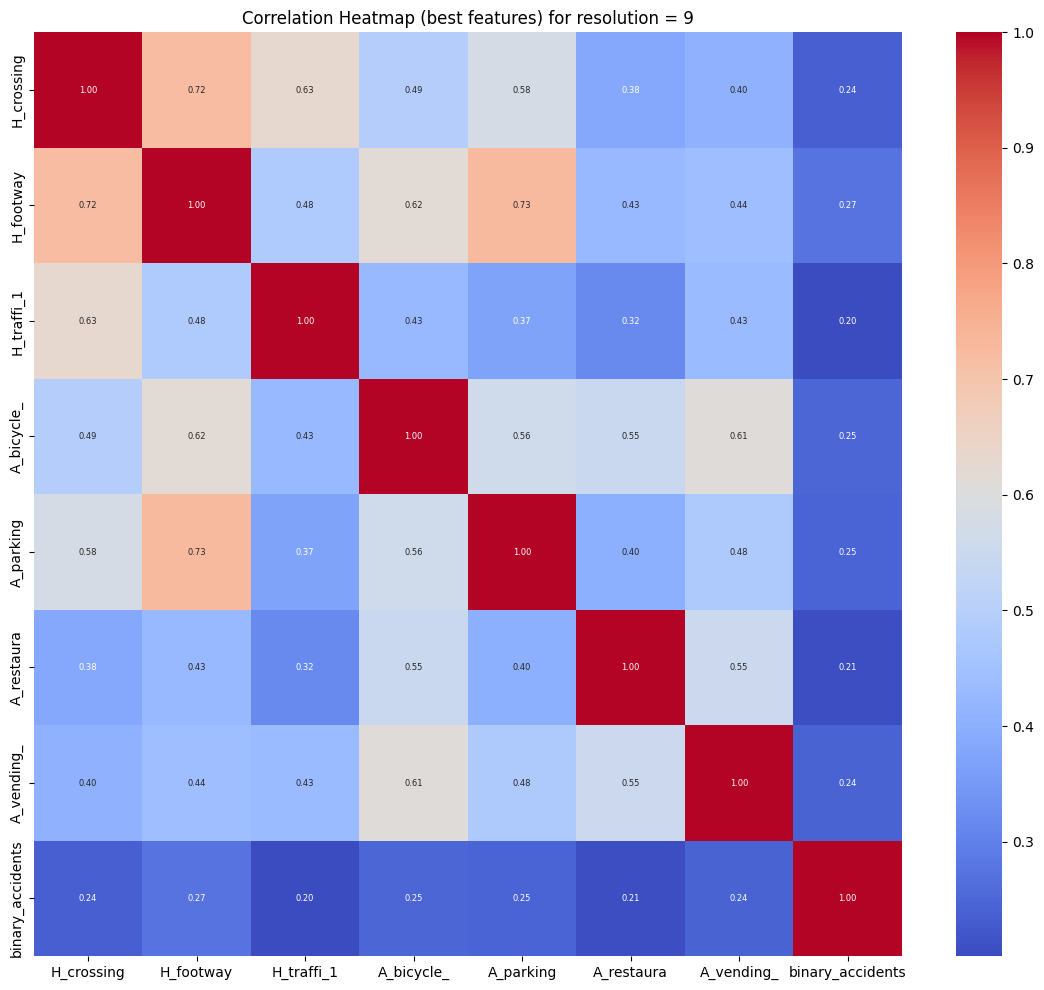

Analysis for Resolution = 10


In [11]:
df_correlation_metrics = pd.DataFrame()

all_high_corr_features = {}
all_low_corr_features = {}

# Loop through resolutions
for resolution in resolutions:
    print(f"Analysis for Resolution = {resolution}")
    merged_gdf = merge_gdf(resolution)
    merged_gdf.reset_index(inplace=True)
    highest_corr_features, low_corr_features, correlation_metrics = correlation_analysis(merged_gdf, resolution)
    all_low_corr_features[resolution] = low_corr_features
    all_high_corr_features[resolution] = highest_corr_features
    df_correlation_metrics = pd.concat([df_correlation_metrics, correlation_metrics], axis=1)


file_path = json_folder_path + f'all_high_corr_features_{city_name}.json'
with open(file_path, 'w') as json_file:
    json.dump(all_high_corr_features, json_file)
    
file_path = json_folder_path + f'all_low_corr_features_{city_name}.json'
with open(file_path, 'w') as json_file:
    json.dump(all_low_corr_features, json_file)

In [12]:
df_correlation_metrics.columns = [f'resolution={resolution}' for resolution in resolutions]
print("Correlation Metrics of Binary Accidents with All Features:")
display(df_correlation_metrics)

Correlation Metrics of Binary Accidents with All Features:


,resolution=8,resolution=9,resolution=10
count,310.000000,310.000000,310.000000
mean,0.093914,0.039148,0.012996
std,0.109517,0.057080,0.023380
min,-0.189427,-0.093156,-0.031720
25%,0.023954,0.001875,-0.000696
50%,0.046338,0.015985,0.004622
75%,0.139368,0.056750,0.014221
max,0.466377,0.274515,0.123701


In [13]:
file_path = json_folder_path + f'all_high_corr_features_{city_name}.json'
with open(file_path, 'r') as json_file:
    all_high_corr_features = json.load(json_file)
    
print("Best Features Based on Correlation:\n")
for resolution, best_features in all_high_corr_features.items():
    print(f"\nResolution {resolution}:")
    for feature in best_features:
        print(f"{feature}")

Best Features Based on Correlation:


Resolution 8:
H_bus_stop
H_crossing
H_cycleway
H_elevator
H_footway
H_living_s
H_pedestri
H_platform
H_resident
H_secondar
H_service
H_steps
H_street_l
H_tertiary
H_traffi_1
R_station
R_tram_cro
R_tram_lev
R_tram_sto
A_atm
A_bank
A_bench
A_bicycle_
A_bicycl_1
A_bicycl_2
A_cafe
A_clinic
A_dentist
A_doctors
A_fast_foo
A_fountain
A_ice_crea
A_kinderga
A_library
A_marketpl
A_parcel_l
A_parking
A_parking_
A_pharmacy
A_place_of
A_police
A_post_box
A_post_off
A_pub
A_restaura
A_school
A_shelter
A_social_f
A_taxi
A_toilets
A_universi
A_vending_
A_veterina
A_waste_ba
A_waste_di

Resolution 9:
H_crossing
H_footway
H_traffi_1
A_bicycle_
A_parking
A_restaura
A_vending_

Resolution 10:


In [14]:
common_features = set(all_high_corr_features['8']) & set(all_high_corr_features['9']) & set(all_high_corr_features['10'])
if common_features != []:
    print("Common Features With High Correlation Across All Resolutions:")
    for feature in common_features:
        print(feature)
    
common_features = set(all_high_corr_features['8']) & set(all_high_corr_features['9'])
if common_features != []:
    print("Common Features With High Correlation Across Resolutions 8 and 9:")
    for feature in common_features:
        print(feature)

Common Features With High Correlation Across All Resolutions:
Common Features With High Correlation Across Resolutions 8 and 9:
H_crossing
H_footway
A_bicycle_
A_parking
A_vending_
H_traffi_1
A_restaura


In [15]:
file_path = json_folder_path + f'all_low_corr_features_{city_name}.json'
with open(file_path, 'r') as json_file:
    all_low_corr_features = json.load(json_file)


common_features = set(all_low_corr_features['8']) & set(all_low_corr_features['9']) & set(all_low_corr_features['10'])
if common_features != []:
    print("Common Features With Low Correlation Across All Resolutions:")
    for feature in common_features:
        print(feature)

Common Features With Low Correlation Across All Resolutions:
H_planned
R_radio
R_dismantl
A_theatre
A_cosmetic
R_rail
A_convent
A_prep_sch
A_construc
R_level_cr
A_car_rent
A_bus_park
A_feeding_
A_traffic_
A_driving_
H_construc
A_conferen
A_money_tr
A_post_dep
A_food
A_student_
A_Cities L
A_funeral_
A_ministry
A_clock
R_service_
RO_ferry
A_weighbri
A_juice_ba
R_stop
R_derail
A_college
H_stop
A_spa
A_stock_ex
R_tram
R_loadin_1
A_shower
A_social_c
A_dog_wash
A_translat
A_letter_b
R_construc
H_mini_rou
H_turning_
H_unclassi
H_second_1
A_insuranc
A_studio
A_photo
A_lounge
H_give_way
R_halt
A_charging
R_crossing
A_coworkin
A_doctor
H_bridlewa
R_loading_
A_stage
A_lawyer
A_love_hot
A_financia
R_defect_d
H_speed_ca
A_gym
A_boat_ren
A_table
R_spur_jun
A_internet
A_bbq
A_drinking
A_parcel_p
A_research
R_subway
A_washing_
A_sports_c
A_food_cou
A_trolley_
R_wash
A_hospital
R_junction
A_left_lug
A_car_shar
RO_inline_
R_mileston
A_canteen
A_hammock
R_signal_b
R_track_sc
A_vacuum_c
A_payment_
A_court

### Istotne cechy

In [16]:
file_path = json_folder_path + f'all_high_corr_features_{city_name}.json'
with open(file_path, 'r') as json_file:
    all_high_corr_features = json.load(json_file)
    
# Loop through resolutions
for resolution in resolutions:
    print(f"Analysis for Resolution = {resolution}")
    merged_gdf = merge_gdf(resolution)
    merged_gdf.reset_index(inplace=True)
    highest_corr_features = all_high_corr_features[str(resolution)]
    
    # Summary statistics of numerical columns
    summary_statistics = merged_gdf.describe()

    all_high_imbalance_features = []
    
    feature_groups = [FeatureGoups.AMENITY, FeatureGoups.HIGHWAY, FeatureGoups.RAILWAY, FeatureGoups.ROUTE]
    for feature_group in feature_groups:
        feature_group_columns = list(merged_gdf.columns[merged_gdf.columns.str.startswith(feature_group.value)])
        mean_row = summary_statistics[feature_group_columns].loc['mean']
        sorted_columns = mean_row.sort_values().index
        summary_statistics_sorted = summary_statistics[sorted_columns]
        print(f"\nSummary Statistics of Numerical Columns (Sorted by Mean) for {feature_group.name}:")
        display(summary_statistics_sorted)
        all_high_imbalance_features.extend(analyze_imbalance(merged_gdf, feature_group))
        highest_imbalance_features_dict[resolution] = all_high_imbalance_features
        

    filtered_columns = summary_statistics.columns[summary_statistics.loc['mean'] > 1]
    common_features_mean_more_than_1 = set(filtered_columns) & set(highest_corr_features)
    if common_features_mean_more_than_1:
        print(f"\nCommon features with mean in hex more than 1 and high correlation:")
        print(common_features_mean_more_than_1)
    else:
        print(f"\nThere is no common features with mean in hex more than 1 and high correlation.")
        
    filtered_columns = summary_statistics.columns[summary_statistics.loc['mean'] < 0.01]
    common_features_mean_less_than_001 = set(filtered_columns) & set(highest_corr_features)
    if common_features_mean_less_than_001:
        print(f"\nCommon features with mean in hex less than 0.01 and high correlation:")
        print(common_features_mean_less_than_001)
    else:
        print(f"\nThere is no common features with mean in hex less than 0.01 and high correlation.")
        
    common_features_highest_corr_and_imbalance = set(all_high_imbalance_features) & set(highest_corr_features)
    if common_features_highest_corr_and_imbalance:
        print(f"\nCommon features with high imbalance and high correlation:")
        print(common_features_highest_corr_and_imbalance)
    else:
        print(f"\nThere is no common features with high imbalance and high correlation.")
    

file_path = json_folder_path + f'highest_imbalance_features_dict_{city_name}.json'
with open(file_path, 'w') as json_file:
    json.dump(highest_imbalance_features_dict, json_file)

Analysis for Resolution = 8

Summary Statistics of Numerical Columns (Sorted by Mean) for AMENITY:


,A_construc,A_lost_and,A_locker,A_left_lug,A_laundry_,A_karaoke_,A_kancel_1,A_wifi,A_insuranc,A_harbourm,A_give_box,A_gambling,A_Cities L,A_food,A_financia,A_film_stu,A_events_c,A_estate_a,A_employme,A_dog_wash,A_doctor,A_delivery,A_crypt,A_cosmetic,A_lounge,A_freeshop,A_ministry,A_movie_st,A_washing_,A_various,A_translat,A_traffic,A_studen_1,A_student_,A_stock_ex,A_statisti,A_stage,A_sports_c,A_spa,A_social_1,A_securi_1,A_security,A_sanitary,A_register,A_recordin,A_pole,A_planetar,A_piano,A_photo,A_parcel_p,A_nursing_,A_modelowa,A_cooking_,A_juice_ba,A_wine_bar,A_car_shar,A_canteen,A_bus_park,A_border_c,A_clothes,A_bakery,A_baggage_,A_baby_hat,A_animal_t,A_animal_1,A_basin,A_animal_b,A_adult_ga,A_computer,A_Kancelar,A_concert_,A_table,A_grave_ya,A_watering,A_car_pool,A_water_po,A_letter_b,A_food_sha,A_cremator,A_love_hot,A_money_tr,A_boat_ren,A_payment_,A_telephon,A_public_b,A_exhibiti,A_publishe,A_social_c,A_accounti,A_dog_park,A_gym,A_post_dep,A_presbyte,A_hammock,A_lawyer,A_internet,A_swingerc,A_binocula,A_conferen,A_funeral_,A_hunting_,A_office,A_coworkin,A_fixme,A_flight_s,A_brothel,A_luggage_,A_shower,A_retail,A_feeding_,A_driver_t,A_photo_bo,A_dormitor,A_weighbri,A_dancing_,A_archive,A_prep_sch,A_public_2,A_animal_s,A_prison,A_stripclu,A_dojo,A_casino,A_check_in,A_ferry_te,A_convent,A_warehous,A_traffic_,A_dressing,A_motorcyc,A_bbq,A_loading_,A_biergart,A_smoking_,A_proposed,A_events_v,A_carpet_h,A_monaster,A_public_1,A_food_cou,A_townhall,A_courthou,A_vacuum_c,A_bus_stat,A_clock,A_music_sc,A_cinema,A_fire_sta,A_compress,A_paymen_1,A_studio,A_driving_,A_trolley_,A_car_rent,A_training,A_research,A_vehicle_,A_nightclu,A_hospital,A_theatre,A_marketpl,A_enclosin,A_childcar,A_language,A_police,A_arts_cen,A_college,A_communit,A_taxi,A_bureau_d,A_drinking,A_lounger,A_bicycl_2,A_charging,A_grit_bin,A_pub,A_social_f,A_veterina,A_universi,A_ice_crea,A_car_wash,A_clinic,A_fuel,A_library,A_fountain,A_post_off,A_recyclin,A_post_box,A_bar,A_place_of,A_bicycl_1,A_bank,A_toilets,A_dentist,A_doctors,A_pharmacy,A_cafe,A_waste_di,A_school,A_atm,A_kinderga,A_fast_foo,A_parcel_l,A_restaura,A_parking_,A_vending_,A_shelter,A_bicycle_,A_waste_ba,A_bench,A_parkin_1,A_parking
count,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.0000


Metrics of Imbalance in AMENITY


count    212.000000
mean       0.533915
std        0.280393
min        0.000000
25%        0.337500
50%        0.495000
75%        0.710000
max        1.000000
Name: 1, dtype: float64


There are 106 high imbalance features in AMENITY:
A_accounti
A_adult_ga
A_animal_1
A_archive
A_arts_cen
A_atm
A_baby_hat
A_baggage_
A_bakery
A_bank
A_bar
A_basin
A_bicycle_
A_bicycl_1
A_boat_ren
A_bureau_d
A_bus_park
A_cafe
A_canteen
A_car_shar
A_carpet_h
A_casino
A_cinema
A_clinic
A_clock
A_college
A_concert_
A_convent
A_cooking_
A_cosmetic
A_courthou
A_coworkin
A_cremator
A_dancing_
A_doctor
A_doctors
A_dog_wash
A_dojo
A_dormitor
A_driver_t
A_employme
A_enclosin
A_estate_a
A_events_c
A_exhibiti
A_fast_foo
A_financia
A_flight_s
A_food
A_fountain
A_gambling
A_grit_bin
A_gym
A_hammock
A_harbourm
A_hunting_
A_ice_crea
A_insuranc
A_internet
A_karaoke_
A_lawyer
A_left_lug
A_locker
A_love_hot
A_luggage_
A_marketpl
A_ministry
A_monaster
A_money_tr
A_movie_st
A_nightclu
A_office
A_payment_
A_photo
A_photo_bo
A_piano
A_planetar
A_pole
A_police
A_post_dep
A_prep_sch
A_pub
A_public_b
A_public_2
A_restaura
A_security
A_securi_1
A_shower
A_spa
A_stage
A_stock_ex
A_stripclu
A_student_
A_studen_1
A

,A_accounti,A_adult_ga,A_animal_1,A_archive,A_arts_cen,A_atm,A_baby_hat,A_baggage_,A_bakery,A_bank,A_bar,A_basin,A_bicycle_,A_bicycl_1,A_boat_ren,A_bureau_d,A_bus_park,A_cafe,A_canteen,A_car_shar,A_carpet_h,A_casino,A_cinema,A_clinic,A_clock,A_college,A_concert_,A_convent,A_cooking_,A_cosmetic,A_courthou,A_coworkin,A_cremator,A_dancing_,A_doctor,A_doctors,A_dog_wash,A_dojo,A_dormitor,A_driver_t,A_employme,A_enclosin,A_estate_a,A_events_c,A_exhibiti,A_fast_foo,A_financia,A_flight_s,A_food,A_fountain,A_gambling,A_grit_bin,A_gym,A_hammock,A_harbourm,A_hunting_,A_ice_crea,A_insuranc,A_internet,A_karaoke_,A_lawyer,A_left_lug,A_locker,A_love_hot,A_luggage_,A_marketpl,A_ministry,A_monaster,A_money_tr,A_movie_st,A_nightclu,A_office,A_payment_,A_photo,A_photo_bo,A_piano,A_planetar,A_pole,A_police,A_post_dep,A_prep_sch,A_pub,A_public_b,A_public_2,A_restaura,A_security,A_securi_1,A_shower,A_spa,A_stage,A_stock_ex,A_stripclu,A_student_,A_studen_1,A_swingerc,A_taxi,A_theatre,A_translat,A_universi,A_vacuum_c,A_vending_,A_warehous,A_waste_ba,A_watering,A_wifi,A_wine_bar
binary_accidents,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.142857,0.0,1.0,0.238095,0.247312,0.229098,0.0,0.0,0.142857,0.204801,0.137181,0.142857,0.236706,0.245817,0.214286,0.169719,0.142857,0.182145,0.0,0.142857,0.196429,0.040816,0.228571,0.204082,0.15873,0.176046,0.0,0.174603,0.142857,0.0,0.080745,0.178571,0.928571,0.057143,0.0,0.233679,0.0,0.122449,0.228571,0.228571,0.0,0.142857,0.0,0.0,0.142857,0.211263,0.0,0.785714,0.0,0.190083,0.142857,0.174036,0.142857,0.0,0.142857,0.96,0.24263,0.857143,0.095238,0.0,0.190476,0.0,0.0,0.214286,0.214286,0.19958,0.0,0.120301,0.0,0.142857,0.077694,0.178571,0.142857,0.0,0.142857,0.0,0.0,0.0,0.219512,0.809524,0.214286,0.185981,0.142857,0.214286,0.236092,0.0,0.0,0.107143,0.0,0.142857,0.0,0.122449,0.0,0.142857,0.238095,0.183312,0.12987,0.0,0.238587,0.238095,0.108196,0.047619,0.251181,0.142857,0.0,0.0
1,0.857143,1.0,0.0,0.761905,0.752688,0.770902,1.0,1.0,0.857143,0.795199,0.862819,0.857143,0.763294,0.754183,0.785714,0.830281,0.857143,0.817855,1.0,0.857143,0.803571,0.959184,0.771429,0.795918,0.84127,0.823954,1.0,0.825397,0.857143,1.0,0.919255,0.821429,0.071429,0.942857,1.0,0.766321,1.0,0.877551,0.771429,0.771429,1.0,0.857143,1.0,1.0,0.857143,0.788737,1.0,0.214286,1.0,0.809917,0.857143,0.825964,0.857143,1.0,0.857143,0.04,0.75737,0.142857,0.904762,1.0,0.809524,1.0,1.0,0.785714,0.785714,0.80042,1.0,0.879699,1.0,0.857143,0.922306,0.821429,0.857143,1.0,0.857143,1.0,1.0,1.0,0.780488,0.190476,0.785714,0.814019,0.857143,0.785714,0.763908,1.0,1.0,0.892857,1.0,0.857143,1.0,0.877551,1.0,0.857143,0.761905,0.816688,0.87013,1.0,0.761413,0.761905,0.891804,0.952381,0.748819,0.857143,1.0,1.0



Summary Statistics of Numerical Columns (Sorted by Mean) for HIGHWAY:


,H_emergenc,H_cyclist_,H_planned,H_turnin_1,H_passing_,H_bridlewa,H_mini_rou,H_raceway,H_motorway,H_speed_ca,H_corridor,H_traffic_,H_mileston,H_stop,H_tertia_1,H_elevator,H_second_1,H_trunk_li,H_trunk,H_unclassi,H_primary_,H_turning_,H_pedestri,H_construc,H_proposed,H_give_way,H_primary,H_traffi_1,H_platform,H_bus_stop,H_living_s,H_track,H_secondar,H_tertiary,H_cycleway,H_steps,H_path,H_resident,H_street_l,H_crossing,H_service,H_footway
count,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.00000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000
mean,0.001235,0.002469,0.004938,0.006173,0.015344,0.017108,0.021869,0.024868,0.058377,0.061552,0.070370,0.078660,0.098236,0.210229,0.226808,0.470370,0.501940,0.515873,0.589242,0.650441,0.799824,0.845326,0.902116,1.507407,1.569665,1.981305,2.085538,3.785891,4.387302,4.80776,4.929277,5.185891,6.254850,8.108818,8.549912,9.415344,16.042857,17.366138,22.250970,31.340564,76.757848,144.485362
std,0.035118,0.049633,0.085932,0.078331,0.170947,0.257312,0.162278,0.371762,0.282267,0.379748,0.798981,0.456412,0.343855,0.983136,0.954636,1.796516,2.897724,2.752765,2.200416,2.149024,3.530723,1.762156,3.351588,9.438002,4.289777,5.979798,5.583907,6.382499,5.613586,4.83323,9.886288,7.597872,11.155429,12.345299,14.722813,21.178953,17.235528,16.149274,43.365618,38.399409,81.762669,202.077833
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,4.000000,0.000000,1.000000,19.000000,6.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,4.00000,1.000000,3.000000,0.000000,3.000000,2.000000,1.000000,11.000000,14.000000,6.000000,14.000000,54.000000,40.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.000000,2.000000,0.000000,6.000000,7.000000,8.00000,5.000000,7.000000,10.000000,11.000000,12.000000,9.000000,23.000000,25.000000,26.000000,52.000000,112.000000,214.000000
max,1.000000,1.000000,2.000000,1.000000,3.000000,5.000000,2.000000,7.000000,3.000000,5.000000,16.000000,6.000000,3.000000,16.000000,15.000000,19.000000,51.000000,33.000000,18.000000,21.000000,37.000000,20.000000,57.000000,226.000000,66.000000,146.000000,40.000000,40.000000,33.000000,25.00000,89.000000,97.000000,63.000000,79.000000,104.000000,205.000000,136.000000,102.000000,505.000000,226.000000,841.000000,1063.000000



Metrics of Imbalance in HIGHWAY


count    42.000000
mean      0.309762
std       0.211204
min       0.060000
25%       0.140000
50%       0.290000
75%       0.415000
max       0.980000
Name: 1, dtype: float64


There are 7 high imbalance features in HIGHWAY:
H_bridlewa
H_corridor
H_cyclist_
H_elevator
H_emergenc
H_pedestri
H_track


,H_bridlewa,H_corridor,H_cyclist_,H_elevator,H_emergenc,H_pedestri,H_track
binary_accidents,,,,,,,
0,0.989691,0.110276,0.214286,0.236595,0.142857,0.25044,0.751836
1,0.010309,0.889724,0.785714,0.763405,0.857143,0.74956,0.248164



Summary Statistics of Numerical Columns (Sorted by Mean) for RAILWAY:


,R_razed,RO_bicycle,R_water_cr,R_traverse,R_spur_jun,R_site,RO_piste,R_defect_d,R_track_sc,R_fuel,R_loadin_1,R_turntabl,R_junction,R_pit,RO_histori,R_hump_yar,R_crossi_1,R_service_,R_yard,R_workshop,R_wash,R_ventilat,R_loading_,R_radio,R_engine_s,RO_ferry,RO_inline_,R_dismantl,R_preheati,R_rail_bra,R_halt,R_signal_b,R_station,R_derail,R_railway_,R_platform,R_platfo_1,R_crossing,R_stop,R_construc,R_subway_e,R_proposed,R_subway,R_mileston,R_abandone,R_buffer_s,R_tram_sto,R_disused,R_level_cr,R_tram_lev,R_tram_cro,R_tram,R_switch,R_signal,R_rail
count,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000
mean,0.001235,0.001235,0.001235,0.001235,0.001235,0.001235,0.001235,0.002469,0.002469,0.002469,0.003175,0.003704,0.003704,0.003704,0.003704,0.003704,0.004938,0.006173,0.006173,0.006173,0.007407,0.008642,0.009877,0.009877,0.009877,0.014286,0.017284,0.019400,0.023457,0.041975,0.048677,0.055556,0.065432,0.094709,0.162963,0.211287,0.217813,0.267901,0.269312,0.307407,0.371605,0.389771,0.434568,0.521693,0.670194,0.733510,0.762963,0.834921,0.928748,1.340741,1.585185,2.233333,2.932099,3.114462,4.509700
std,0.035118,0.035118,0.035118,0.035118,0.035118,0.035118,0.035118,0.070236,0.049633,0.049633,0.056259,0.078487,0.060751,0.078487,0.105353,0.078487,0.070105,0.078331,0.078331,0.105238,0.121501,0.135820,0.248278,0.098898,0.140211,0.128661,0.457837,0.275368,0.507464,1.194006,0.226396,0.290831,0.261859,0.493411,1.148632,0.775902,1.237105,1.366384,1.003061,2.426524,1.866417,1.800149,2.532248,3.469059,2.592418,3.089319,2.033995,3.555112,5.428689,4.936315,5.079651,9.681744,12.196883,12.667510,16.489732
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


Metrics of Imbalance in RAILWAY


count    55.000000
mean      0.400364
std       0.301361
min       0.000000
25%       0.140000
50%       0.330000
75%       0.590000
max       1.000000
Name: 1, dtype: float64


There are 20 high imbalance features in RAILWAY:
R_defect_d
R_hump_yar
R_junction
R_loading_
R_rail_bra
R_razed
R_site
R_spur_jun
R_station
R_subway_e
R_tram
R_tram_cro
R_tram_lev
R_tram_sto
R_turntabl
R_ventilat
R_wash
RO_histori
RO_inline_
RO_piste


,R_defect_d,R_hump_yar,R_junction,R_loading_,R_rail_bra,R_razed,R_site,R_spur_jun,R_station,R_subway_e,R_tram,R_tram_cro,R_tram_lev,R_tram_sto,R_turntabl,R_ventilat,R_wash,RO_histori,RO_inline_,RO_piste
binary_accidents,,,,,,,,,,,,,,,,,,,,
0,1.0,0.761905,0.809524,0.839286,0.857143,1.0,0.0,1.0,0.204852,0.159468,0.228303,0.20316,0.180742,0.240638,0.238095,0.102041,0.238095,0.0,0.0,0.142857
1,0.0,0.238095,0.190476,0.160714,0.142857,0.0,1.0,0.0,0.795148,0.840532,0.771697,0.79684,0.819258,0.759362,0.761905,0.897959,0.761905,1.0,1.0,0.857143



Summary Statistics of Numerical Columns (Sorted by Mean) for ROUTE:


,RO_bicycle,RO_piste,RO_histori,RO_ferry,RO_inline_
count,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000
mean,0.001235,0.001235,0.003704,0.014286,0.017284
std,0.035118,0.035118,0.105353,0.128661,0.457837
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,3.000000,2.000000,13.000000



Metrics of Imbalance in ROUTE


count    5.000000
mean     0.636000
std      0.408693
min      0.040000
25%      0.430000
50%      0.710000
75%      1.000000
max      1.000000
Name: 1, dtype: float64


There are 3 high imbalance features in ROUTE:
RO_histori
RO_inline_
RO_piste


,RO_histori,RO_inline_,RO_piste
binary_accidents,,,
0,0.0,0.0,0.142857
1,1.0,1.0,0.857143



Common features with mean in hex more than 1 and high correlation:
{'H_platform', 'H_crossing', 'A_atm', 'A_parking_', 'R_tram_cro', 'H_street_l', 'A_shelter', 'A_waste_ba', 'A_kinderga', 'H_secondar', 'H_tertiary', 'H_steps', 'R_tram_lev', 'A_bench', 'A_restaura', 'A_school', 'H_cycleway', 'H_resident', 'H_living_s', 'A_parcel_l', 'H_traffi_1', 'H_footway', 'H_bus_stop', 'A_waste_di', 'A_fast_foo', 'A_bicycle_', 'A_parking', 'H_service', 'A_vending_'}

There is no common features with mean in hex less than 0.01 and high correlation.

Common features with high imbalance and high correlation:
{'R_tram_sto', 'A_universi', 'A_atm', 'A_clinic', 'R_station', 'R_tram_cro', 'A_fountain', 'A_waste_ba', 'A_cafe', 'A_marketpl', 'R_tram_lev', 'A_restaura', 'A_ice_crea', 'A_bicycl_1', 'A_bank', 'H_pedestri', 'A_doctors', 'A_pub', 'A_taxi', 'H_elevator', 'A_fast_foo', 'A_police', 'A_bicycle_', 'A_vending_'}
Analysis for Resolution = 9

Summary Statistics of Numerical Columns (Sorted by Mean) for A

,A_animal_1,A_Cities L,A_left_lug,A_laundry_,A_karaoke_,A_kancel_1,A_wifi,A_insuranc,A_harbourm,A_give_box,A_gambling,A_freeshop,A_food,A_financia,A_film_stu,A_events_c,A_estate_a,A_employme,A_dog_wash,A_doctor,A_delivery,A_crypt,A_locker,A_lost_and,A_lounge,A_ministry,A_washing_,A_various,A_translat,A_studen_1,A_student_,A_stock_ex,A_spa,A_social_1,A_securi_1,A_security,A_sanitary,A_register,A_recordin,A_pole,A_planetar,A_piano,A_photo,A_parcel_p,A_nursing_,A_movie_st,A_modelowa,A_cosmetic,A_cooking_,A_juice_ba,A_wine_bar,A_canteen,A_border_c,A_car_shar,A_concert_,A_basin,A_baggage_,A_baby_hat,A_animal_b,A_clothes,A_bakery,A_bus_park,A_adult_ga,A_Kancelar,A_computer,A_payment_,A_money_tr,A_water_po,A_public_b,A_publishe,A_gym,A_food_sha,A_love_hot,A_cremator,A_boat_ren,A_sports_c,A_stage,A_construc,A_letter_b,A_table,A_dog_park,A_telephon,A_accounti,A_social_c,A_watering,A_hammock,A_grave_ya,A_internet,A_binocula,A_funeral_,A_traffic,A_presbyte,A_lawyer,A_exhibiti,A_swingerc,A_statisti,A_animal_t,A_flight_s,A_fixme,A_retail,A_luggage_,A_coworkin,A_shower,A_office,A_hunting_,A_car_pool,A_brothel,A_photo_bo,A_weighbri,A_archive,A_conferen,A_dancing_,A_feeding_,A_dormitor,A_post_dep,A_public_2,A_prep_sch,A_check_in,A_driver_t,A_casino,A_stripclu,A_animal_s,A_dojo,A_traffic_,A_warehous,A_ferry_te,A_convent,A_dressing,A_loading_,A_motorcyc,A_bbq,A_prison,A_biergart,A_smoking_,A_events_v,A_carpet_h,A_public_1,A_proposed,A_monaster,A_vacuum_c,A_courthou,A_food_cou,A_townhall,A_clock,A_bus_stat,A_music_sc,A_cinema,A_compress,A_paymen_1,A_studio,A_car_rent,A_trolley_,A_fire_sta,A_driving_,A_training,A_vehicle_,A_nightclu,A_theatre,A_research,A_enclosin,A_language,A_childcar,A_arts_cen,A_marketpl,A_police,A_college,A_hospital,A_communit,A_bureau_d,A_taxi,A_drinking,A_lounger,A_bicycl_2,A_charging,A_pub,A_grit_bin,A_veterina,A_ice_crea,A_social_f,A_clinic,A_car_wash,A_library,A_fuel,A_fountain,A_post_off,A_recyclin,A_post_box,A_universi,A_bar,A_bicycl_1,A_place_of,A_bank,A_toilets,A_dentist,A_doctors,A_pharmacy,A_cafe,A_waste_di,A_atm,A_school,A_fast_foo,A_kinderga,A_parcel_l,A_restaura,A_parking_,A_vending_,A_shelter,A_bicycle_,A_waste_ba,A_bench,A_parkin_1,A_parking
count,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,382


Metrics of Imbalance in AMENITY


count    212.000000
mean       0.511321
std        0.256429
min        0.000000
25%        0.360000
50%        0.500000
75%        0.710000
max        1.000000
Name: 1, dtype: float64


There are 107 high imbalance features in AMENITY:
A_Cities L
A_accounti
A_adult_ga
A_animal_b
A_animal_1
A_animal_s
A_animal_t
A_bakery
A_basin
A_bbq
A_bench
A_biergart
A_binocula
A_boat_ren
A_border_c
A_bus_park
A_bus_stat
A_canteen
A_car_pool
A_car_rent
A_car_shar
A_car_wash
A_carpet_h
A_check_in
A_childcar
A_compress
A_conferen
A_construc
A_cremator
A_crypt
A_dog_park
A_dog_wash
A_dressing
A_drinking
A_driver_t
A_driving_
A_enclosin
A_estate_a
A_events_v
A_ferry_te
A_film_stu
A_fire_sta
A_flight_s
A_food_cou
A_food_sha
A_freeshop
A_fuel
A_funeral_
A_gambling
A_give_box
A_grave_ya
A_gym
A_hospital
A_hunting_
A_insuranc
A_kinderga
A_laundry_
A_letter_b
A_loading_
A_lost_and
A_lounge
A_love_hot
A_ministry
A_motorcyc
A_music_sc
A_nursing_
A_office
A_parcel_l
A_parcel_p
A_parking
A_parking_
A_parkin_1
A_place_of
A_police
A_post_dep
A_presbyte
A_prison
A_proposed
A_publishe
A_recordin
A_recyclin
A_register
A_retail
A_sanitary
A_school
A_securi_1
A_shelter
A_smoking_
A_social_c
A_social_f

,A_Cities L,A_accounti,A_adult_ga,A_animal_b,A_animal_1,A_animal_s,A_animal_t,A_bakery,A_basin,A_bbq,A_bench,A_biergart,A_binocula,A_boat_ren,A_border_c,A_bus_park,A_bus_stat,A_canteen,A_car_pool,A_car_rent,A_car_shar,A_car_wash,A_carpet_h,A_check_in,A_childcar,A_compress,A_conferen,A_construc,A_cremator,A_crypt,A_dog_park,A_dog_wash,A_dressing,A_drinking,A_driver_t,A_driving_,A_enclosin,A_estate_a,A_events_v,A_ferry_te,A_film_stu,A_fire_sta,A_flight_s,A_food_cou,A_food_sha,A_freeshop,A_fuel,A_funeral_,A_gambling,A_give_box,A_grave_ya,A_gym,A_hospital,A_hunting_,A_insuranc,A_kinderga,A_laundry_,A_letter_b,A_loading_,A_lost_and,A_lounge,A_love_hot,A_ministry,A_motorcyc,A_music_sc,A_nursing_,A_office,A_parcel_l,A_parcel_p,A_parking,A_parking_,A_parkin_1,A_place_of,A_police,A_post_dep,A_presbyte,A_prison,A_proposed,A_publishe,A_recordin,A_recyclin,A_register,A_retail,A_sanitary,A_school,A_securi_1,A_shelter,A_smoking_,A_social_c,A_social_f,A_social_1,A_stage,A_statisti,A_studen_1,A_table,A_telephon,A_traffic,A_traffic_,A_universi,A_vacuum_c,A_various,A_vehicle_,A_veterina,A_waste_di,A_water_po,A_watering,A_weighbri
binary_accidents,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.785714,0.857143,0.857143,1.0,0.897959,1.0,0.857143,0.857143,0.948052,0.754513,0.857143,0.857143,0.857143,0.857143,0.857143,0.780952,0.857143,0.75,0.756757,1.0,0.804605,0.839286,0.857143,0.794425,0.792208,0.828571,0.857143,1.0,1.0,0.785714,1.0,0.857143,0.768,0.755102,0.81685,0.923077,0.857143,0.776786,0.777778,0.857143,0.831502,1.0,0.794286,0.857143,0.857143,0.790123,0.952381,0.857143,0.857143,0.761905,0.785714,0.747638,0.964286,1.0,0.806722,1.0,0.857143,0.922078,0.857143,0.857143,0.857143,0.857143,0.779221,0.818605,1.0,0.785714,0.78292,1.0,0.757364,0.785767,0.768471,0.776359,0.767507,1.0,0.857143,0.955556,0.8,0.857143,1.0,0.803704,0.857143,1.0,1.0,0.763054,0.857143,0.765216,0.780952,0.785714,0.804444,0.857143,1.0,0.857143,0.857143,0.857143,0.857143,0.809524,0.84127,0.748982,0.809524,1.0,0.823245,0.775769,0.760203,1.0,0.785714,0.971429
1,0.0,0.214286,0.142857,0.142857,0.0,0.102041,0.0,0.142857,0.142857,0.051948,0.245487,0.142857,0.142857,0.142857,0.142857,0.142857,0.219048,0.142857,0.25,0.243243,0.0,0.195395,0.160714,0.142857,0.205575,0.207792,0.171429,0.142857,0.0,0.0,0.214286,0.0,0.142857,0.232,0.244898,0.18315,0.076923,0.142857,0.223214,0.222222,0.142857,0.168498,0.0,0.205714,0.142857,0.142857,0.209877,0.047619,0.142857,0.142857,0.238095,0.214286,0.252362,0.035714,0.0,0.193278,0.0,0.142857,0.077922,0.142857,0.142857,0.142857,0.142857,0.220779,0.181395,0.0,0.214286,0.21708,0.0,0.242636,0.214233,0.231529,0.223641,0.232493,0.0,0.142857,0.044444,0.2,0.142857,0.0,0.196296,0.142857,0.0,0.0,0.236946,0.142857,0.234784,0.219048,0.214286,0.195556,0.142857,0.0,0.142857,0.142857,0.142857,0.142857,0.190476,0.15873,0.251018,0.190476,0.0,0.176755,0.224231,0.239797,0.0,0.214286,0.028571



Summary Statistics of Numerical Columns (Sorted by Mean) for HIGHWAY:


,H_emergenc,H_cyclist_,H_planned,H_turnin_1,H_passing_,H_mini_rou,H_raceway,H_bridlewa,H_motorway,H_speed_ca,H_corridor,H_traffic_,H_mileston,H_stop,H_tertia_1,H_elevator,H_second_1,H_trunk_li,H_turning_,H_unclassi,H_trunk,H_primary_,H_pedestri,H_construc,H_give_way,H_proposed,H_primary,H_traffi_1,H_platform,H_bus_stop,H_living_s,H_track,H_secondar,H_steps,H_tertiary,H_cycleway,H_path,H_street_l,H_resident,H_crossing,H_service,H_footway
count,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000
mean,0.000183,0.000366,0.000733,0.000916,0.002382,0.003271,0.004475,0.005496,0.008663,0.009160,0.011175,0.011699,0.014525,0.031459,0.038630,0.070638,0.085713,0.094428,0.126436,0.128033,0.129472,0.142689,0.162449,0.241645,0.302075,0.352247,0.397210,0.562119,0.707739,0.715198,0.878903,1.047005,1.133764,1.420634,1.459447,1.500222,2.996205,3.306027,3.414955,4.661310,12.796619,23.955089
std,0.013534,0.019138,0.027061,0.030252,0.055757,0.057104,0.132247,0.111481,0.096545,0.142952,0.292916,0.148957,0.121166,0.318100,0.335589,0.561594,0.886106,0.855617,0.496327,0.732516,0.763771,1.183535,1.009517,3.343151,1.682407,1.408484,1.722311,1.575690,1.480234,1.271062,2.592069,2.220444,3.279563,4.534172,3.404565,3.984516,4.792737,8.643314,4.086302,7.497871,16.851443,37.878820
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,8.000000,5.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,4.000000,2.000000,5.000000,7.000000,18.000000,33.000000
max,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,7.000000,4.000000,2.000000,5.000000,15.000000,6.000000,2.000000,12.000000,8.000000,13.000000,27.000000,19.000000,9.000000,17.000000,10.000000,33.000000,36.000000,216.000000,77.000000,33.000000,23.000000,16.000000,18.000000,15.000000,35.000000,46.000000,45.000000,80.000000,33.000000,45.000000,70.000000,109.000000,32.000000,57.000000,233.000000,269.000000



Metrics of Imbalance in HIGHWAY


count    42.000000
mean      0.607857
std       0.183749
min       0.000000
25%       0.505000
50%       0.605000
75%       0.727500
max       1.000000
Name: 1, dtype: float64


There are 32 high imbalance features in HIGHWAY:
H_bridlewa
H_bus_stop
H_crossing
H_cycleway
H_emergenc
H_footway
H_give_way
H_living_s
H_mileston
H_mini_rou
H_motorway
H_passing_
H_path
H_pedestri
H_planned
H_platform
H_primary
H_primary_
H_proposed
H_raceway
H_resident
H_secondar
H_second_1
H_service
H_stop
H_street_l
H_tertiary
H_track
H_trunk
H_trunk_li
H_turning_
H_unclassi


,H_bridlewa,H_bus_stop,H_crossing,H_cycleway,H_emergenc,H_footway,H_give_way,H_living_s,H_mileston,H_mini_rou,H_motorway,H_passing_,H_path,H_pedestri,H_planned,H_platform,H_primary,H_primary_,H_proposed,H_raceway,H_resident,H_secondar,H_second_1,H_service,H_stop,H_street_l,H_tertiary,H_track,H_trunk,H_trunk_li,H_turning_,H_unclassi
binary_accidents,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.81081,0.783722,0.759813,0.857143,0.768042,0.806793,0.825591,0.881081,0.824,0.864048,0.89011,0.898744,0.762043,0.857143,0.774351,0.79324,0.760455,0.882532,0.976608,0.84391,0.74783,0.759389,0.826016,0.851082,0.765294,0.798006,0.958455,0.893269,0.861696,0.891948,0.871627
1,0.0,0.18919,0.216278,0.240187,0.142857,0.231958,0.193207,0.174409,0.118919,0.176,0.135952,0.10989,0.101256,0.237957,0.142857,0.225649,0.20676,0.239545,0.117468,0.023392,0.15609,0.25217,0.240611,0.173984,0.148918,0.234706,0.201994,0.041545,0.106731,0.138304,0.108052,0.128373



Summary Statistics of Numerical Columns (Sorted by Mean) for RAILWAY:


,RO_bicycle,R_water_cr,R_traverse,R_spur_jun,R_site,R_razed,R_track_sc,R_fuel,RO_piste,R_defect_d,R_hump_yar,R_junction,R_turntabl,R_pit,R_crossi_1,RO_histori,R_loadin_1,R_service_,R_yard,R_wash,R_workshop,R_radio,R_ventilat,R_loading_,R_engine_s,R_dismantl,R_preheati,RO_ferry,RO_inline_,R_rail_bra,R_halt,R_signal_b,R_station,R_derail,R_railway_,R_crossing,R_stop,R_platform,R_platfo_1,R_subway_e,R_construc,R_mileston,R_proposed,R_buffer_s,R_tram_sto,R_subway,R_level_cr,R_abandone,R_disused,R_tram_lev,R_tram_cro,R_switch,R_signal,R_tram,R_rail
count,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.00000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000
mean,0.000183,0.000183,0.000183,0.000183,0.000183,0.000366,0.000366,0.000366,0.000366,0.000366,0.000550,0.000550,0.000550,0.000550,0.000733,0.000733,0.000733,0.000916,0.000916,0.001099,0.001282,0.001466,0.001466,0.001466,0.001649,0.003429,0.003481,0.003743,0.004030,0.006229,0.007302,0.008244,0.00971,0.014107,0.024183,0.039991,0.040017,0.043602,0.043681,0.055144,0.062237,0.077233,0.099846,0.108953,0.113219,0.117067,0.138187,0.151378,0.173205,0.198958,0.235233,0.435264,0.462326,0.470282,1.060693
std,0.013534,0.013534,0.013534,0.013534,0.013534,0.019138,0.019138,0.019138,0.019138,0.027068,0.030261,0.023438,0.023438,0.023438,0.027061,0.038277,0.027061,0.030252,0.030252,0.046875,0.044874,0.038256,0.054122,0.085593,0.052397,0.094409,0.183071,0.063993,0.154275,0.313890,0.087265,0.092427,0.09806,0.164618,0.373835,0.445904,0.341803,0.328510,0.518151,0.625917,0.909050,0.832952,0.698918,0.785045,0.564612,0.951935,1.338105,0.862610,1.258989,1.375424,1.413656,2.902449,2.912135,3.181596,5.180894
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.


Metrics of Imbalance in RAILWAY


count    55.000000
mean      0.690364
std       0.249466
min       0.140000
25%       0.485000
50%       0.710000
75%       0.895000
max       1.000000
Name: 1, dtype: float64


There are 41 high imbalance features in RAILWAY:
R_abandone
R_buffer_s
R_construc
R_crossing
R_crossi_1
R_defect_d
R_derail
R_disused
R_engine_s
R_fuel
R_halt
R_hump_yar
R_junction
R_level_cr
R_loading_
R_loadin_1
R_mileston
R_pit
R_preheati
R_proposed
R_radio
R_rail
R_rail_bra
R_railway_
R_razed
R_service_
R_signal
R_signal_b
R_site
R_spur_jun
R_subway
R_switch
R_track_sc
R_traverse
R_wash
R_water_cr
R_workshop
R_yard
RO_bicycle
RO_ferry
RO_piste


,R_abandone,R_buffer_s,R_construc,R_crossing,R_crossi_1,R_defect_d,R_derail,R_disused,R_engine_s,R_fuel,R_halt,R_hump_yar,R_junction,R_level_cr,R_loading_,R_loadin_1,R_mileston,R_pit,R_preheati,R_proposed,R_radio,R_rail,R_rail_bra,R_railway_,R_razed,R_service_,R_signal,R_signal_b,R_site,R_spur_jun,R_subway,R_switch,R_track_sc,R_traverse,R_wash,R_water_cr,R_workshop,R_yard,RO_bicycle,RO_ferry,RO_piste
binary_accidents,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.895401,0.891184,0.776703,0.89856,0.928571,1.0,0.907236,0.821094,0.857143,1.0,0.806452,0.952381,1.0,0.953977,1.0,0.892857,0.88038,1.0,1.0,0.856881,0.892857,0.902882,1.0,0.823593,1.0,0.942857,0.890292,0.857143,0.857143,1.0,0.759446,0.879502,0.857143,1.0,0.761905,1.0,0.77551,0.914286,1.0,0.825175,0.857143
1,0.104599,0.108816,0.223297,0.10144,0.071429,0.0,0.092764,0.178906,0.142857,0.0,0.193548,0.047619,0.0,0.046023,0.0,0.107143,0.11962,0.0,0.0,0.143119,0.107143,0.097118,0.0,0.176407,0.0,0.057143,0.109708,0.142857,0.142857,0.0,0.240554,0.120498,0.142857,0.0,0.238095,0.0,0.22449,0.085714,0.0,0.174825,0.142857



Summary Statistics of Numerical Columns (Sorted by Mean) for ROUTE:


,RO_bicycle,RO_piste,RO_histori,RO_ferry,RO_inline_
count,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000
mean,0.000183,0.000366,0.000733,0.003743,0.004030
std,0.013534,0.019138,0.038277,0.063993,0.154275
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,2.000000,2.000000,9.000000



Metrics of Imbalance in ROUTE


count    5.000000
mean     0.564000
std      0.338423
min      0.140000
25%      0.320000
50%      0.650000
75%      0.710000
max      1.000000
Name: 1, dtype: float64


There are 3 high imbalance features in ROUTE:
RO_bicycle
RO_ferry
RO_piste


,RO_bicycle,RO_ferry,RO_piste
binary_accidents,,,
0,1.0,0.825175,0.857143
1,0.0,0.174825,0.142857



Common features with mean in hex more than 1 and high correlation:
{'A_parking', 'H_crossing', 'H_footway'}

There is no common features with mean in hex less than 0.01 and high correlation.

Common features with high imbalance and high correlation:
{'A_parking', 'H_crossing', 'H_footway'}
Analysis for Resolution = 10

Summary Statistics of Numerical Columns (Sorted by Mean) for AMENITY:


,A_Cities L,A_left_lug,A_laundry_,A_karaoke_,A_kancel_1,A_wifi,A_insuranc,A_harbourm,A_give_box,A_gambling,A_locker,A_freeshop,A_financia,A_film_stu,A_events_c,A_estate_a,A_employme,A_dog_wash,A_doctor,A_delivery,A_crypt,A_food,A_lost_and,A_lounge,A_modelowa,A_washing_,A_various,A_translat,A_studen_1,A_student_,A_stock_ex,A_stage,A_sports_c,A_spa,A_social_1,A_securi_1,A_security,A_sanitary,A_register,A_recordin,A_pole,A_planetar,A_piano,A_photo,A_parcel_p,A_movie_st,A_cosmetic,A_cooking_,A_juice_ba,A_wine_bar,A_canteen,A_bus_park,A_border_c,A_computer,A_basin,A_bakery,A_baggage_,A_baby_hat,A_animal_1,A_clothes,A_car_shar,A_Kancelar,A_animal_b,A_adult_ga,A_table,A_food_sha,A_watering,A_water_po,A_letter_b,A_boat_ren,A_love_hot,A_ministry,A_accounti,A_public_b,A_social_c,A_gym,A_publishe,A_statisti,A_telephon,A_cremator,A_payment_,A_dog_park,A_hammock,A_car_pool,A_animal_t,A_nursing_,A_lawyer,A_binocula,A_traffic,A_presbyte,A_internet,A_money_tr,A_concert_,A_flight_s,A_shower,A_grave_ya,A_office,A_construc,A_swingerc,A_hunting_,A_luggage_,A_fixme,A_coworkin,A_brothel,A_photo_bo,A_dormitor,A_feeding_,A_dancing_,A_exhibiti,A_prep_sch,A_weighbri,A_funeral_,A_retail,A_archive,A_stripclu,A_casino,A_dojo,A_check_in,A_conferen,A_public_2,A_warehous,A_ferry_te,A_animal_s,A_convent,A_driver_t,A_loading_,A_bbq,A_dressing,A_smoking_,A_motorcyc,A_biergart,A_events_v,A_carpet_h,A_proposed,A_traffic_,A_post_dep,A_public_1,A_vacuum_c,A_prison,A_clock,A_music_sc,A_food_cou,A_compress,A_paymen_1,A_studio,A_monaster,A_bus_stat,A_courthou,A_car_rent,A_cinema,A_trolley_,A_townhall,A_driving_,A_training,A_fire_sta,A_vehicle_,A_nightclu,A_language,A_theatre,A_childcar,A_enclosin,A_college,A_bureau_d,A_arts_cen,A_communit,A_lounger,A_taxi,A_drinking,A_bicycl_2,A_charging,A_pub,A_grit_bin,A_veterina,A_marketpl,A_police,A_research,A_ice_crea,A_car_wash,A_library,A_clinic,A_post_off,A_fountain,A_fuel,A_post_box,A_recyclin,A_hospital,A_bar,A_social_f,A_bicycl_1,A_bank,A_place_of,A_toilets,A_dentist,A_doctors,A_pharmacy,A_universi,A_cafe,A_waste_di,A_atm,A_fast_foo,A_parcel_l,A_kinderga,A_restaura,A_school,A_parking_,A_vending_,A_shelter,A_bicycle_,A_waste_ba,A_bench,A_parkin_1,A_parking
count,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,26351


Metrics of Imbalance in AMENITY


count    212.000000
mean       0.882028
std        0.141415
min        0.050000
25%        0.850000
50%        0.910000
75%        1.000000
max        1.000000
Name: 1, dtype: float64


There are 206 high imbalance features in AMENITY:
A_Cities L
A_Kancelar
A_accounti
A_adult_ga
A_animal_b
A_animal_1
A_animal_s
A_animal_t
A_archive
A_arts_cen
A_atm
A_baby_hat
A_bakery
A_bank
A_bar
A_basin
A_bbq
A_bench
A_bicycle_
A_bicycl_1
A_bicycl_2
A_biergart
A_binocula
A_boat_ren
A_border_c
A_brothel
A_bureau_d
A_bus_park
A_bus_stat
A_cafe
A_canteen
A_car_pool
A_car_rent
A_car_shar
A_car_wash
A_carpet_h
A_casino
A_charging
A_check_in
A_childcar
A_cinema
A_clinic
A_clock
A_college
A_communit
A_compress
A_concert_
A_conferen
A_construc
A_convent
A_cooking_
A_courthou
A_coworkin
A_cremator
A_crypt
A_dancing_
A_delivery
A_dentist
A_doctor
A_doctors
A_dog_park
A_dog_wash
A_dojo
A_dormitor
A_dressing
A_drinking
A_driver_t
A_driving_
A_employme
A_enclosin
A_estate_a
A_events_c
A_events_v
A_exhibiti
A_fast_foo
A_feeding_
A_ferry_te
A_film_stu
A_financia
A_fire_sta
A_fixme
A_flight_s
A_food
A_food_cou
A_food_sha
A_fountain
A_freeshop
A_fuel
A_funeral_
A_gambling
A_give_box
A_grave_ya
A_gr

,A_Cities L,A_Kancelar,A_accounti,A_adult_ga,A_animal_b,A_animal_1,A_animal_s,A_animal_t,A_archive,A_arts_cen,A_atm,A_baby_hat,A_bakery,A_bank,A_bar,A_basin,A_bbq,A_bench,A_bicycle_,A_bicycl_1,A_bicycl_2,A_biergart,A_binocula,A_boat_ren,A_border_c,A_brothel,A_bureau_d,A_bus_park,A_bus_stat,A_cafe,A_canteen,A_car_pool,A_car_rent,A_car_shar,A_car_wash,A_carpet_h,A_casino,A_charging,A_check_in,A_childcar,A_cinema,A_clinic,A_clock,A_college,A_communit,A_compress,A_concert_,A_conferen,A_construc,A_convent,A_cooking_,A_courthou,A_coworkin,A_cremator,A_crypt,A_dancing_,A_delivery,A_dentist,A_doctor,A_doctors,A_dog_park,A_dog_wash,A_dojo,A_dormitor,A_dressing,A_drinking,A_driver_t,A_driving_,A_employme,A_enclosin,A_estate_a,A_events_c,A_events_v,A_exhibiti,A_fast_foo,A_feeding_,A_ferry_te,A_film_stu,A_financia,A_fire_sta,A_fixme,A_flight_s,A_food,A_food_cou,A_food_sha,A_fountain,A_freeshop,A_fuel,A_funeral_,A_gambling,A_give_box,A_grave_ya,A_grit_bin,A_gym,A_hammock,A_harbourm,A_hospital,A_hunting_,A_ice_crea,A_insuranc,A_internet,A_juice_ba,A_kancel_1,A_karaoke_,A_kinderga,A_language,A_laundry_,A_lawyer,A_left_lug,A_letter_b,A_library,A_loading_,A_locker,A_lost_and,A_lounge,A_lounger,A_love_hot,A_luggage_,A_marketpl,A_ministry,A_modelowa,A_monaster,A_motorcyc,A_movie_st,A_music_sc,A_nightclu,A_nursing_,A_office,A_parcel_l,A_parcel_p,A_parking,A_parking_,A_parkin_1,A_payment_,A_paymen_1,A_pharmacy,A_photo,A_photo_bo,A_piano,A_place_of,A_planetar,A_pole,A_police,A_post_box,A_post_dep,A_post_off,A_prep_sch,A_presbyte,A_prison,A_proposed,A_pub,A_public_b,A_public_1,A_public_2,A_publishe,A_recordin,A_recyclin,A_register,A_research,A_restaura,A_retail,A_sanitary,A_school,A_security,A_securi_1,A_shelter,A_shower,A_smoking_,A_social_c,A_social_f,A_social_1,A_sports_c,A_stage,A_statisti,A_stock_ex,A_stripclu,A_student_,A_studen_1,A_studio,A_swingerc,A_table,A_taxi,A_telephon,A_theatre,A_toilets,A_townhall,A_traffic,A_traffic_,A_training,A_translat,A_trolley_,A_universi,A_vacuum_c,A_various,A_vehicle_,A_vending_,A_veterina,A_warehous,A_washing_,A_waste_ba,A_waste_di,A_water_po,A_watering,A_weighbri,A_wifi,A_wine_bar
binary_accidents,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,1.0,0.928571,1.0,1.0,1.0,0.985714,1.0,0.959184,0.939976,0.899457,1.0,1.0,0.897357,0.922207,1.0,1.0,0.958644,0.930439,0.911565,0.922751,0.946429,1.0,1.0,1.0,0.942857,0.876847,1.0,0.912698,0.914962,1.0,0.904762,0.949807,1.0,0.941356,0.964286,0.938776,0.938197,1.0,0.980031,0.928571,0.939516,0.933673,0.957393,0.946429,0.922078,0.857143,0.982143,0.964286,0.942857,0.857143,0.916667,0.928571,1.0,1.0,0.942857,0.857143,0.93323,1.0,0.933722,0.857143,1.0,0.959184,0.942857,0.989011,0.961039,1.0,0.965157,0.857143,1.0,1.0,0.857143,0.991071,1.0,0.910343,0.971429,0.952381,1.0,1.0,0.984694,0.892857,1.0,1.0,0.969697,1.0,0.958147,1.0,0.932984,1.0,1.0,1.0,0.75,0.903195,1.0,0.857143,0.857143,0.9615,1.0,0.934181,1.0,0.809524,0.857143,1.0,0.857143,0.972965,0.9375,1.0,0.952381,0.857143,0.928571,0.944251,0.961039,0.857143,1.0,1.0,0.940199,1.0,0.892857,0.934339,0.928571,1.0,0.95102,0.989796,1.0,0.958525,0.944196,1.0,0.964286,0.943644,1.0,0.952948,0.955715,0.958326,0.857143,0.987395,0.930897,0.857143,0.885714,0.857143,0.952941,0.857143,0.857143,0.959059,0.928315,1.0,0.94161,0.952381,1.0,0.994898,0.984127,0.922932,1.0,0.964286,1.0,0.928571,1.0,0.978671,1.0,0.954978,0.930823,1.0,1.0,0.963401,0.857143,1.0,0.924703,0.964286,0.989796,0.928571,0.968305,0.857143,0.857143,1.0,1.0,1.0,0.877551,0.857143,1.0,0.934694,0.964286,0.857143,0.904396,1.0,0.932874,0.927261,0.945055,0.952381,0.992063,0.932773,1.0,0.932331,0.961822,0.928571,1.0,0.954649,0.900276,0.949686,0.920635,0.857143,0.93025,0.963208,1.0,1.0,1.0,0.857143,0.857143
1,0.0,0.0,0.071429,0.0,0.0,0.0,0.014286,0.0,0.040816,0.060024,0.100543,0.0,0.0,0.102643,0.077793,0.0,0.0,0.041356,0.06956


Summary Statistics of Numerical Columns (Sorted by Mean) for HIGHWAY:


,H_emergenc,H_cyclist_,H_turnin_1,H_planned,H_passing_,H_mini_rou,H_raceway,H_motorway,H_speed_ca,H_traffic_,H_corridor,H_bridlewa,H_mileston,H_stop,H_tertia_1,H_elevator,H_second_1,H_turning_,H_trunk_li,H_unclassi,H_primary_,H_pedestri,H_trunk,H_give_way,H_construc,H_traffi_1,H_primary,H_proposed,H_bus_stop,H_platform,H_living_s,H_steps,H_secondar,H_track,H_cycleway,H_tertiary,H_street_l,H_path,H_crossing,H_resident,H_service,H_footway
count,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000
mean,0.000027,0.000053,0.000133,0.000239,0.000345,0.000474,0.001256,0.001271,0.001328,0.001700,0.002019,0.002072,0.002137,0.004569,0.006478,0.010254,0.016815,0.018378,0.022219,0.029771,0.030552,0.035493,0.035744,0.043891,0.045075,0.081506,0.090488,0.097797,0.103907,0.124065,0.188866,0.214124,0.241546,0.258357,0.301330,0.308070,0.479764,0.671172,0.676626,0.815563,2.396133,4.459545
std,0.005154,0.007289,0.011524,0.015460,0.019958,0.021775,0.058460,0.035632,0.049953,0.047766,0.100978,0.059179,0.046745,0.113297,0.124155,0.158694,0.278239,0.154498,0.297017,0.271523,0.353391,0.336414,0.321812,0.369432,0.863548,0.479240,0.603193,0.572116,0.395956,0.499721,0.770271,1.055718,1.063742,0.774188,1.274403,1.140866,1.813369,1.503971,1.817584,1.341254,3.813148,7.957949
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,3.000000,6.000000
max,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,7.000000,1.000000,5.000000,4.000000,12.000000,4.000000,2.000000,15.000000,8.000000,8.000000,21.000000,5.000000,11.000000,11.000000,16.000000,19.000000,7.000000,20.000000,100.000000,10.000000,13.000000,28.000000,12.000000,15.000000,19.000000,27.000000,25.000000,20.000000,33.000000,20.000000,33.000000,29.000000,29.000000,18.000000,54.000000,85.000000



Metrics of Imbalance in HIGHWAY


count    42.000000
mean      0.889762
std       0.084145
min       0.570000
25%       0.850000
50%       0.910000
75%       0.940000
max       1.000000
Name: 1, dtype: float64


There are 42 high imbalance features in HIGHWAY:
H_bridlewa
H_bus_stop
H_construc
H_corridor
H_crossing
H_cycleway
H_cyclist_
H_elevator
H_emergenc
H_footway
H_give_way
H_living_s
H_mileston
H_mini_rou
H_motorway
H_passing_
H_path
H_pedestri
H_planned
H_platform
H_primary
H_primary_
H_proposed
H_raceway
H_resident
H_secondar
H_second_1
H_service
H_speed_ca
H_steps
H_stop
H_street_l
H_tertiary
H_tertia_1
H_track
H_traffic_
H_traffi_1
H_trunk
H_trunk_li
H_turning_
H_turnin_1
H_unclassi


,H_bridlewa,H_bus_stop,H_construc,H_corridor,H_crossing,H_cycleway,H_cyclist_,H_elevator,H_emergenc,H_footway,H_give_way,H_living_s,H_mileston,H_mini_rou,H_motorway,H_passing_,H_path,H_pedestri,H_planned,H_platform,H_primary,H_primary_,H_proposed,H_raceway,H_resident,H_secondar,H_second_1,H_service,H_speed_ca,H_steps,H_stop,H_street_l,H_tertiary,H_tertia_1,H_track,H_traffic_,H_traffi_1,H_trunk,H_trunk_li,H_turning_,H_turnin_1,H_unclassi
binary_accidents,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.941383,0.937784,0.881579,0.943736,0.925584,0.785714,0.907476,1.0,0.952818,0.953398,0.974181,0.966252,0.976,0.970149,0.956044,0.982631,0.957233,0.968254,0.926467,0.924051,0.925351,0.98056,0.969789,0.973091,0.920457,0.905439,0.967052,0.911429,0.939318,0.968439,0.935859,0.949545,0.922671,0.994697,0.96875,0.909908,0.965814,0.966524,0.977906,0.828571,0.967878
1,0.0,0.058617,0.062216,0.118421,0.056264,0.074416,0.214286,0.092524,0.0,0.047182,0.046602,0.025819,0.033748,0.024,0.029851,0.043956,0.017369,0.042767,0.031746,0.073533,0.075949,0.074649,0.01944,0.030211,0.026909,0.079543,0.094561,0.032948,0.088571,0.060682,0.031561,0.064141,0.050455,0.077329,0.005303,0.03125,0.090092,0.034186,0.033476,0.022094,0.171429,0.032122



Summary Statistics of Numerical Columns (Sorted by Mean) for RAILWAY:


,R_water_cr,R_spur_jun,R_site,RO_bicycle,R_defect_d,R_traverse,R_track_sc,R_fuel,RO_piste,R_hump_yar,R_junction,R_pit,R_yard,R_turntabl,R_service_,R_razed,R_crossi_1,R_loadin_1,RO_histori,R_ventilat,R_loading_,R_radio,R_wash,R_workshop,R_engine_s,R_preheati,R_dismantl,RO_ferry,R_rail_bra,RO_inline_,R_halt,R_signal_b,R_station,R_derail,R_railway_,R_crossing,R_stop,R_subway_e,R_platform,R_mileston,R_platfo_1,R_buffer_s,R_tram_sto,R_construc,R_level_cr,R_tram_lev,R_proposed,R_tram_cro,R_subway,R_abandone,R_disused,R_switch,R_signal,R_tram,R_rail
count,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000
mean,0.000027,0.000027,0.000027,0.000053,0.000053,0.000053,0.000053,0.000053,0.000080,0.000080,0.000080,0.000080,0.000133,0.000133,0.000133,0.000133,0.000133,0.000148,0.000159,0.000213,0.000213,0.000213,0.000239,0.000345,0.000425,0.000505,0.000759,0.000839,0.000903,0.000983,0.001063,0.001408,0.001408,0.002045,0.003506,0.005814,0.005814,0.007996,0.010880,0.011237,0.011620,0.015806,0.016417,0.016568,0.020067,0.028848,0.029793,0.034108,0.036074,0.040176,0.044180,0.063116,0.067074,0.117838,0.302806
std,0.005154,0.005154,0.005154,0.007289,0.010308,0.007289,0.007289,0.007289,0.008927,0.011524,0.008927,0.008927,0.011524,0.013636,0.011524,0.011524,0.011524,0.012165,0.016298,0.020615,0.024174,0.014576,0.019960,0.021248,0.024171,0.053311,0.038067,0.029851,0.103334,0.057615,0.032580,0.037496,0.037496,0.053771,0.129318,0.152111,0.119278,0.159907,0.152643,0.207845,0.237105,0.224280,0.182212,0.319180,0.351069,0.435040,0.327382,0.422008,0.428654,0.345401,0.477622,0.680801,0.680136,1.094419,1.833445
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00


Metrics of Imbalance in RAILWAY


count    55.000000
mean      0.931091
std       0.084583
min       0.710000
25%       0.880000
50%       0.960000
75%       1.000000
max       1.000000
Name: 1, dtype: float64


There are 55 high imbalance features in RAILWAY:
R_abandone
R_buffer_s
R_construc
R_crossing
R_crossi_1
R_defect_d
R_derail
R_dismantl
R_disused
R_engine_s
R_fuel
R_halt
R_hump_yar
R_junction
R_level_cr
R_loading_
R_loadin_1
R_mileston
R_pit
R_platform
R_platfo_1
R_preheati
R_proposed
R_radio
R_rail
R_rail_bra
R_railway_
R_razed
R_service_
R_signal
R_signal_b
R_site
R_spur_jun
R_station
R_stop
R_subway
R_subway_e
R_switch
R_track_sc
R_tram
R_tram_cro
R_tram_lev
R_tram_sto
R_traverse
R_turntabl
R_ventilat
R_wash
R_water_cr
R_workshop
R_yard
RO_bicycle
RO_ferry
RO_histori
RO_inline_
RO_piste


,R_abandone,R_buffer_s,R_construc,R_crossing,R_crossi_1,R_defect_d,R_derail,R_dismantl,R_disused,R_engine_s,R_fuel,R_halt,R_hump_yar,R_junction,R_level_cr,R_loading_,R_loadin_1,R_mileston,R_pit,R_platform,R_platfo_1,R_preheati,R_proposed,R_radio,R_rail,R_rail_bra,R_railway_,R_razed,R_service_,R_signal,R_signal_b,R_site,R_spur_jun,R_station,R_stop,R_subway,R_subway_e,R_switch,R_track_sc,R_tram,R_tram_cro,R_tram_lev,R_tram_sto,R_traverse,R_turntabl,R_ventilat,R_wash,R_water_cr,R_workshop,R_yard,RO_bicycle,RO_ferry,RO_histori,RO_inline_,RO_piste
binary_accidents,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.987249,0.984874,0.948694,0.983029,1.0,1.0,0.988868,0.915,0.968476,1.0,1.0,0.964286,1.0,1.0,0.996596,1.0,0.974359,0.973995,1.0,0.938263,0.937296,1.0,0.965992,0.982143,0.986691,1.0,0.944805,1.0,1.0,0.980537,0.975741,1.0,1.0,0.90027,0.917102,0.925836,0.859516,0.978295,1.0,0.917847,0.894081,0.883583,0.9043,1.0,0.857143,0.964286,1.0,1.0,0.934066,1.0,1.0,0.977376,0.857143,0.942085,1.0
1,0.012751,0.015126,0.051306,0.016971,0.0,0.0,0.011132,0.085,0.031524,0.0,0.0,0.035714,0.0,0.0,0.003404,0.0,0.025641,0.026005,0.0,0.061737,0.062704,0.0,0.034008,0.017857,0.013309,0.0,0.055195,0.0,0.0,0.019463,0.024259,0.0,0.0,0.09973,0.082898,0.074164,0.140484,0.021705,0.0,0.082153,0.105919,0.116417,0.0957,0.0,0.142857,0.035714,0.0,0.0,0.065934,0.0,0.0,0.022624,0.142857,0.057915,0.0



Summary Statistics of Numerical Columns (Sorted by Mean) for ROUTE:


,RO_bicycle,RO_piste,RO_histori,RO_ferry,RO_inline_
count,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000
mean,0.000053,0.000080,0.000159,0.000839,0.000983
std,0.007289,0.008927,0.016298,0.029851,0.057615
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,2.000000,2.000000,7.000000



Metrics of Imbalance in ROUTE


count    5.00000
mean     0.90800
std      0.12112
min      0.71000
25%      0.88000
50%      0.95000
75%      1.00000
max      1.00000
Name: 1, dtype: float64


There are 5 high imbalance features in ROUTE:
RO_bicycle
RO_ferry
RO_histori
RO_inline_
RO_piste


,RO_bicycle,RO_ferry,RO_histori,RO_inline_,RO_piste
binary_accidents,,,,,
0,1.0,0.977376,0.857143,0.942085,1.0
1,0.0,0.022624,0.142857,0.057915,0.0



There is no common features with mean in hex more than 1 and high correlation.

There is no common features with mean in hex less than 0.01 and high correlation.

There is no common features with high imbalance and high correlation.


In [17]:
features_resolution_8 = highest_imbalance_features_dict[8]
features_resolution_9 = highest_imbalance_features_dict[9]
features_resolution_10 = highest_imbalance_features_dict[10]

# Find common features
common_features = set(features_resolution_8) & set(features_resolution_9) & set(features_resolution_10)
if common_features != []:
    print("Common Features With the Highest Imbalance Across All Resolutions:")
    for feature in common_features:
        print(feature)

Common Features With the Highest Imbalance Across All Resolutions:
A_boat_ren
A_enclosin
R_site
A_cremator
R_spur_jun
A_universi
A_carpet_h
R_rail_bra
A_bakery
A_flight_s
A_driver_t
A_office
A_bus_park
A_animal_1
R_wash
R_junction
A_car_shar
A_post_dep
A_canteen
A_vacuum_c
H_track
A_ministry
A_watering
A_hunting_
A_gambling
A_estate_a
H_pedestri
A_adult_ga
A_basin
A_accounti
R_hump_yar
A_dog_wash
RO_piste
H_emergenc
A_insuranc
A_police
R_razed
A_stage
H_bridlewa
R_loading_
A_securi_1
A_love_hot
A_studen_1
R_defect_d
A_gym


### Najczęściej występujące cechy

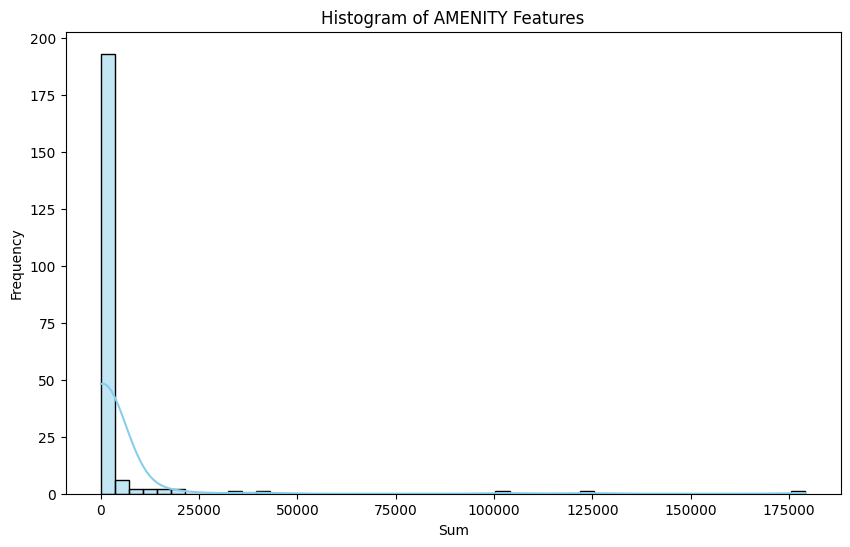

count       212.000000
mean       3282.863208
std       17000.555660
min           7.000000
25%           7.000000
50%          35.000000
75%         598.500000
max      179206.000000
dtype: float64


Most common features for AMENITY: 
 ['A_atm', 'A_bank', 'A_bar', 'A_bench', 'A_bicycle_', 'A_bicycl_1', 'A_cafe', 'A_car_wash', 'A_clinic', 'A_dentist', 'A_doctors', 'A_fast_foo', 'A_fountain', 'A_fuel', 'A_hospital', 'A_kinderga', 'A_library', 'A_parcel_l', 'A_parking', 'A_parking_', 'A_parkin_1', 'A_pharmacy', 'A_place_of', 'A_post_box', 'A_post_off', 'A_recyclin', 'A_restaura', 'A_school', 'A_shelter', 'A_social_f', 'A_toilets', 'A_universi', 'A_vending_', 'A_waste_ba', 'A_waste_di']


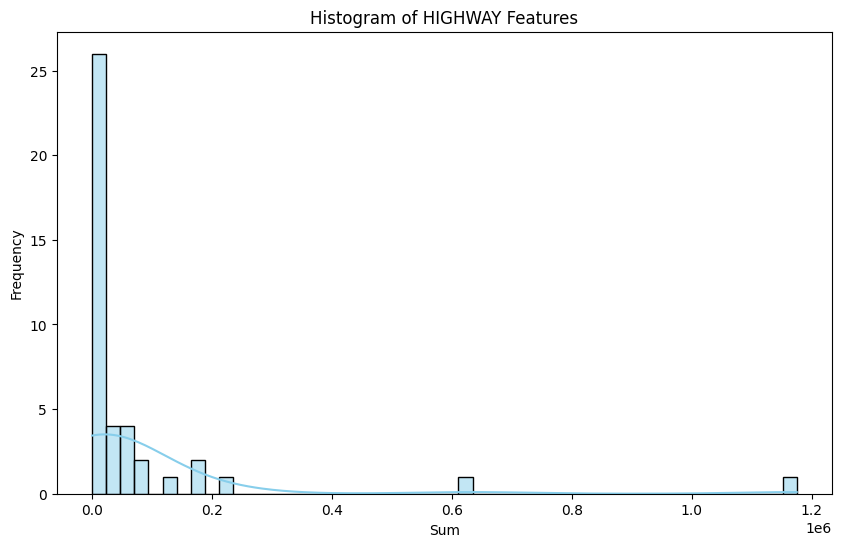

count    4.200000e+01
mean     7.416788e+04
std      2.039435e+05
min      7.000000e+00
25%      5.355000e+02
50%      8.702000e+03
75%      5.476100e+04
max      1.175157e+06
dtype: float64


Most common features for HIGHWAY: 
 ['H_crossing', 'H_footway', 'H_path', 'H_resident', 'H_service']


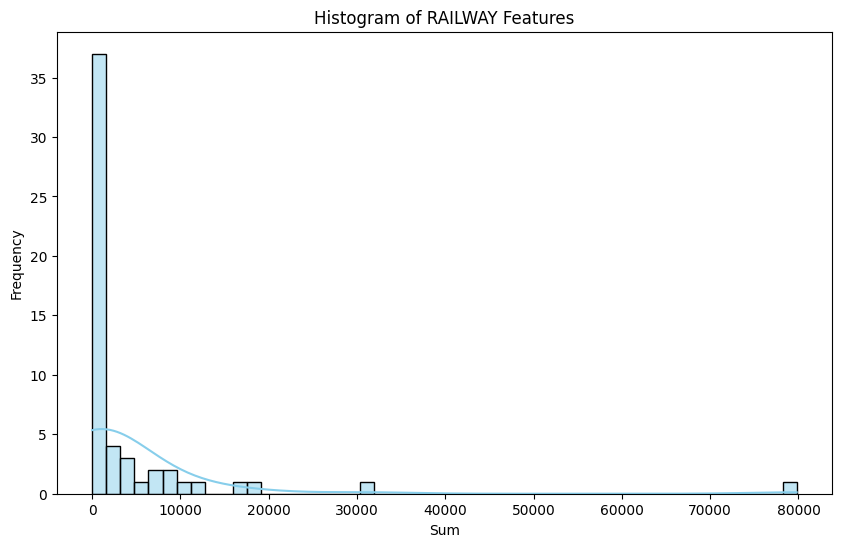

count       55.000000
mean      4326.109091
std      11823.984024
min          7.000000
25%         35.000000
50%        221.000000
75%       3613.500000
max      79794.000000
dtype: float64


Most common features for RAILWAY: 
 ['R_abandone', 'R_disused', 'R_rail', 'R_signal', 'R_subway', 'R_switch', 'R_tram', 'R_tram_cro']


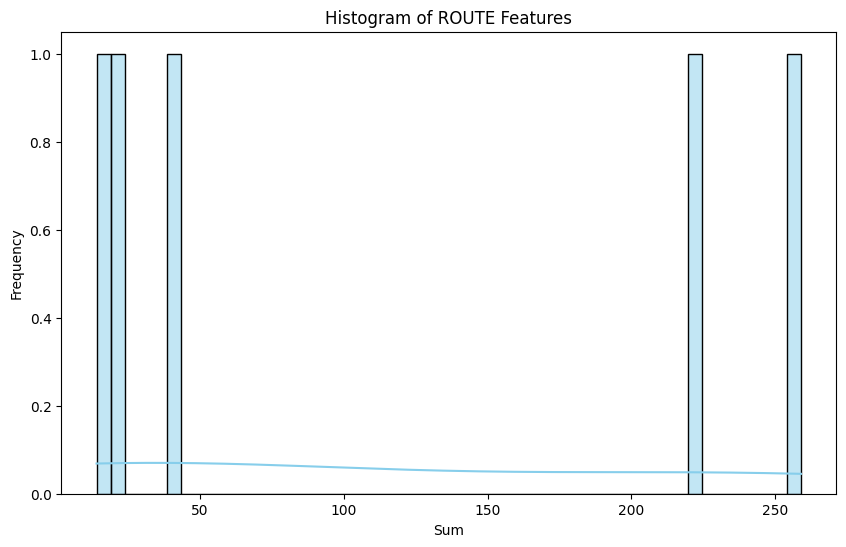

count      5.000000
mean     111.400000
std      118.609865
min       14.000000
25%       21.000000
50%       42.000000
75%      221.000000
max      259.000000
dtype: float64


Most common features for ROUTE: 
 []

All Most Common Features in the City:
A_atm
A_bank
A_bar
A_bench
A_bicycle_
A_bicycl_1
A_cafe
A_car_wash
A_clinic
A_dentist
A_doctors
A_fast_foo
A_fountain
A_fuel
A_hospital
A_kinderga
A_library
A_parcel_l
A_parking
A_parking_
A_parkin_1
A_pharmacy
A_place_of
A_post_box
A_post_off
A_recyclin
A_restaura
A_school
A_shelter
A_social_f
A_toilets
A_universi
A_vending_
A_waste_ba
A_waste_di
H_crossing
H_footway
H_path
H_resident
H_service
R_abandone
R_disused
R_rail
R_signal
R_subway
R_switch
R_tram
R_tram_cro


In [18]:
# resolution=8
# merged_gdf = merge_gdf(resolution)

all_most_common_features = []
feature_groups = [FeatureGoups.AMENITY, FeatureGoups.HIGHWAY, FeatureGoups.RAILWAY, FeatureGoups.ROUTE]
for feature_group in feature_groups:
    all_most_common_features.extend(analyze_features(merged_gdf, feature_group))
    
print(f"\nAll Most Common Features in the City:")
for feature in all_most_common_features:
    print(feature)

### SHAP

Analysis for Resolution = 8


100%|██████████| 1701/1701 [1:03:39<00:00,  2.25s/it]  


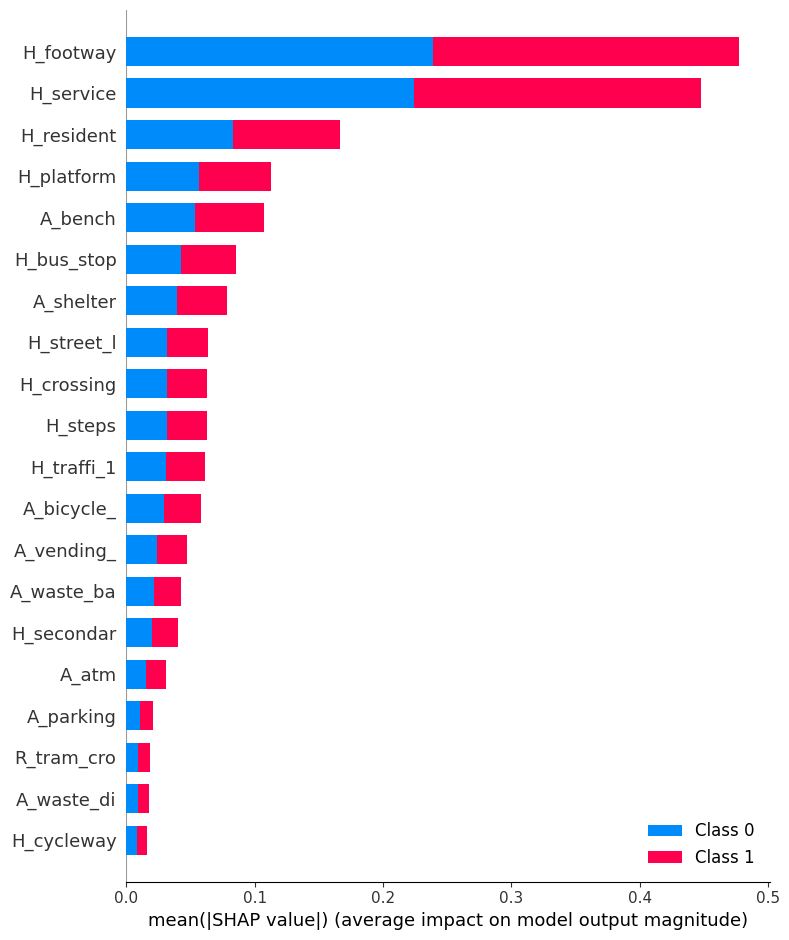

Analysis for Resolution = 9


100%|██████████| 11463/11463 [00:29<00:00, 385.16it/s]


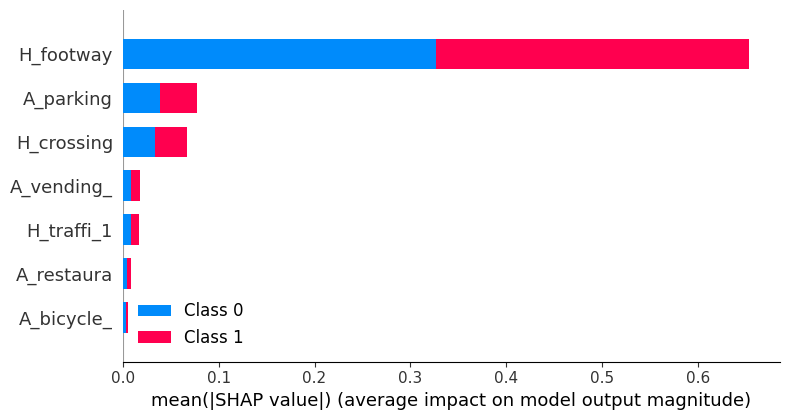

shap.plots.force is slow for many thousands of rows, try subsampling your data.


In [19]:
json_file_path = json_folder_path + f'all_high_corr_features_{city_name}.json'    
with open(json_file_path, 'r') as json_file:
    all_high_corr_features = json.load(json_file)
    
for resolution, highest_corr_features in all_high_corr_features.items():
    if highest_corr_features != []:
        merged_gdf = merge_gdf(resolution)
        shap_analysis(h3_resolution=resolution, merged_gdf=merged_gdf, selected_features=highest_corr_features, save_force_plot=True)
    

### Moran's I

In [20]:
print("Local Moran's I Results:")
for resolution, results in local_moran_results.items():
    print(f"Resolution {resolution}: Moran's I = {results['moran_i']}, p_sim = {results['p_sim']}, q = {results['q']}")

Local Moran's I Results:
Resolution 8: Moran's I = [-0.197291    0.24813422  0.15462003 ...  0.15462003  0.19514284
 -0.0181526 ], p_sim = [0.015 0.001 0.017 ... 0.018 0.003 0.001], q = [4 3 3 ... 3 3 4]
Resolution 9: Moran's I = [0.08391626 0.08391626 0.08391626 ... 0.08391626 0.08391626 0.08391626], p_sim = [0.001 0.001 0.001 ... 0.104 0.001 0.001], q = [3 3 3 ... 3 3 3]
Resolution 10: Moran's I = [-0.10431331  0.0164074  10.27570978 ...  0.0164074   0.0164074
  0.0164074 ], p_sim = [0.001 0.421 0.001 ... 0.322 0.466 0.459], q = [2 3 1 ... 3 3 3]


In [21]:
res = {}
for resolution, results in local_moran_results.items():
    res[resolution] = []
    for key, value in results.items():
        res[resolution].extend([np.mean(value), np.std(value), np.min(value), np.max(value)])

local_moran_metrics = list(local_moran_results.values())[0].keys()
id_names = [f'{key}_{stat}' for key in local_moran_metrics for stat in ['mean', 'std', 'min', 'max']]
        
df = pd.DataFrame(res, index=id_names)
df.columns = [f'resolution={resolution}' for resolution in df.columns]
display(df)

,resolution=8,resolution=9,resolution=10
moran_i_mean,0.564889,0.255955,0.178096
moran_i_std,2.382028,1.559899,2.109681
moran_i_min,-0.827279,-1.261290,-0.949358
moran_i_max,41.089494,56.440299,176.789183
p_sim_mean,0.057523,0.086702,0.378548
p_sim_std,0.117015,0.169932,0.133086
p_sim_min,0.001000,0.001000,0.001000
p_sim_max,0.499000,0.500000,0.500000
q_mean,2.550970,2.572431,2.877396
q_std,1.006747,0.668549,0.378666


#### Wnioski

**moran_i** <br>
Dla rozdzielczości 8 (największe hexy) obserwujemy silniejszy lokalny wzorzec korelacji. Oznacza to, że obszary o podobnych wartościach są bardziej skupione przestrzennie dla większych heksagonów. Odchylenie standardowe jest największe równiez dla rozdzielczości 8, co wskazuje na większą zmienność lokalnej korelacji przestrzennej w obszarach o większych heksagonach.

**p-wartość** <br>
Wartości p_sim są stosunkowo niskie dla wszystkich rozdzielczości, co wskazuje na istotność statystyczną lokalnego wzorca przestrzennej korelacji. Największe wartości p_sim (bliskie 0.5) mogą pochodzić z obszarów o losowym rozkładzie, gdzie brak jest wyraźnych lokalnych wzorców. Wartości minimalne i wartość średnia sugerują, że dla większości obszarów lokalne wzorce korelacji są istotne.

**Q** <br>
Średnie wartości Q dla wszystkich rozdzielczości wskazują na to, że istnieją klastry obszarów o podobnych wartościach w sąsiedztwie. Maksymalna wartość Q dla rozdzielczości 8 i 9 wynosi 4, co sugeruje, że istnieją obszary otoczone przez obszary o podobnych wartościach.